*Alonso Evan*

*03/05/2020*
<a id="12"></a> <br>
## Introduction to the competition and the Data
The data is provided by Home Credit, a service dedicated to provided lines of credit (loans) to the unbanked population. Predicting whether or not a client will repay a loan or have difficulty is a critical business need, and Home Credit is hosting this competition on Kaggle to see what sort of models the machine learning community can develop to help them in this task.

There are 7 different sources of data:

- `application_train/application_test`: the main training and testing data with information about each loan application at Home Credit. 
- `bureau`: data concerning client's previous credits from other financial institutions.
- `bureau_balance`: monthly data about the previous credits in bureau. 
- `previous_application`: previous applications for loans at Home Credit of clients who have loans in the application data. 
- `POS_CASH_BALANCE`: monthly data about previous point of sale or cash loans clients have had with Home Credit. 
- `credit_card_balance`: monthly data about previous credit cards clients have had with Home Credit. 
- `installments_payment`: payment history for previous loans at Home Credit. 


For now, we will stick to using only the main application training and testing data. Although if we want to have any hope of seriously competing, we need to use all the data, for now we will stick to one file which should be more manageable. This will let us establish a baseline that we can then improve upon. With these projects, it's best to build up an understanding of the problem a little at a time rather than diving all the way in and getting completely lost!

In this project, we will use the `ROC AUC` metrics, it's often the case in classification problems.

1. [Introduction to the competition and the Data](#12)
1. [Import packages](#1)
1. [Load data](#2)
1. [Exploratory Data Analysis (EDA)](#3)
    - Distribution of the TARGET column
    - Missing values
    - Columns types
    - Encoding categorical variables
    - Aligning Training and Testing Data
    - Anomalies
    - Correlations
    - Exterior sources
1. [Feature Engineering](#4)
    - Polynomial features
    - Domain Knowledge Features
1. [Implementing our models](#5)
    - Logistic Regression Implementation
    - Random Forest implementation
    - Make Random Forest Predictions using Engineered Features
    - Make Random Forest Predictions using Domain Features
1. [Quick check out on others machine learning models](#6)
    - Basic application data
    - Application data with polynomial features
    - Application data with domains features
    - Submission to Kaggle
1. [Manual feature engineering](#7)
    - Example: Counts of a client's previous loans
    - Usefulness of New Variable
    - Categorical Variables
    - Aggregating Numeric Columns
    - Applying Operations to another dataframe
    - Insert Computed Features into Training Data
1. [Features engineered analysis](#8)
    - Correlations
    - Collinear Variables
1. [Modeling (again)](#9)
    - Create functions
    - control: only the data in the application files
    - Test One : application files / bureau / bureau_balance files
    - Test Two : application / bureau / bureau_balance files with highly correlated variables removed
    - Results
1. [Manual Feature engineering Part 2](#10)
    - Functions
    - previous_application
    - Function to Aggregate Stats at the Client Level
    - Monthly cash data
    - Monthly credit data
    - Installment Payments
1. [Modeling (again)](#11)

<a id="1"></a> <br>
## Import packages

In [74]:
import numpy as np
import pandas as pd 

# sklearn preprocessing for dealing with categorical variables
from sklearn.preprocessing import LabelEncoder, PolynomialFeatures, MinMaxScaler
from sklearn.impute import SimpleImputer

import os

import warnings
warnings.filterwarnings('ignore')


import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score, StratifiedKFold, GridSearchCV, cross_validate
import sklearn.model_selection as ms
from lightgbm import LGBMClassifier
import xgboost as xgb

from sklearn.svm import LinearSVC



from sklearn import tree
from sklearn import metrics
from sklearn import ensemble
from sklearn import linear_model 
from sklearn import naive_bayes 

<a id="2"></a> <br>
## Import data

In [268]:
train = pd.read_csv('application_train.csv')
print('Training data shape: ', train.shape)
train.head()

Training data shape:  (307511, 122)


,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


The training data has 307511 observations (each one a separate loan) and 122 features (variables) including the TARGET (the label we want to predict).

In [269]:
test = pd.read_csv('application_test.csv')
print('Test data shape :',  test.shape)
test.head()

Test data shape : (48744, 121)


,SK_ID_CURR,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100001,Cash loans,F,N,Y,0,135000.0,568800.0,20560.5,450000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
1,100005,Cash loans,M,N,Y,0,99000.0,222768.0,17370.0,180000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,3.0
2,100013,Cash loans,M,Y,Y,0,202500.0,663264.0,69777.0,630000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,1.0,4.0
3,100028,Cash loans,F,N,Y,2,315000.0,1575000.0,49018.5,1575000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,3.0
4,100038,Cash loans,M,Y,N,1,180000.0,625500.0,32067.0,625500.0,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN


The test set is considerably smaller and lacks a TARGET column.

<a id="3"></a> <br>
## Exploratory Data Analysis (EDA)

**Distribution of the TARGET column**

In [7]:
train.TARGET.value_counts()

0    282686
1     24825
Name: TARGET, dtype: int64

In [8]:
train.TARGET.value_counts(normalize = True)

0    0.919271
1    0.080729
Name: TARGET, dtype: float64

We can clearly see an imbalanced class problem. There are far more loans that were repaid on time than loans that were not repaid. That's almost always the case in this kind of problem. Once we get into more sophisticated machine learning models, we can weight the classes by their representation in the data to reflect this imbalance.

**Missing values**

In [14]:
train.isnull().sum().sort_values(ascending = False)

COMMONAREA_MEDI                214865
COMMONAREA_AVG                 214865
COMMONAREA_MODE                214865
NONLIVINGAPARTMENTS_MODE       213514
NONLIVINGAPARTMENTS_MEDI       213514
                                ...  
REG_CITY_NOT_LIVE_CITY              0
LIVE_REGION_NOT_WORK_REGION         0
REG_REGION_NOT_WORK_REGION          0
HOUR_APPR_PROCESS_START             0
SK_ID_CURR                          0
Length: 122, dtype: int64

In [15]:
def missing_values_table(df):
        # Total missing values
        mis_val = df.isnull().sum()
        
        # Percentage of missing values
        mis_val_percent = 100 * df.isnull().sum() / len(df)
        
        # Make a table with the results
        mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
        
        # Rename the columns
        mis_val_table_ren_columns = mis_val_table.rename(
        columns = {0 : 'Missing Values', 1 : '% of Total Values'})
        
        # Sort the table by percentage of missing descending
        mis_val_table_ren_columns = mis_val_table_ren_columns[
            mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
        '% of Total Values', ascending=False).round(1)
        
        # Print some summary information
        print ("Your selected dataframe has " + str(df.shape[1]) + " columns.\n"      
            "There are " + str(mis_val_table_ren_columns.shape[0]) +
              " columns that have missing values.")
        
        # Return the dataframe with missing information
        return mis_val_table_ren_columns

In [17]:
missing_values = missing_values_table(train)
missing_values.head(20)

Your selected dataframe has 122 columns.
There are 67 columns that have missing values.


,Missing Values,% of Total Values
COMMONAREA_MEDI,214865,69.9
COMMONAREA_AVG,214865,69.9
COMMONAREA_MODE,214865,69.9
NONLIVINGAPARTMENTS_MEDI,213514,69.4
NONLIVINGAPARTMENTS_MODE,213514,69.4
NONLIVINGAPARTMENTS_AVG,213514,69.4
FONDKAPREMONT_MODE,210295,68.4
LIVINGAPARTMENTS_MODE,210199,68.4
LIVINGAPARTMENTS_MEDI,210199,68.4
LIVINGAPARTMENTS_AVG,210199,68.4


When it comes time to build our machine learning models, we will have to deal with missing values, we will likely fill them (known as imputation). In later work, we will use models such as XGBoost that can handle missing values with no need for imputation. Another option would be to drop columns with a high percentage of missing values, although it is impossible to know ahead of time if these columns will be helpful to our model. Therefore, we will keep all of the columns for now.

**Columns types**

In [19]:
train.dtypes.value_counts()

float64    65
int64      41
object     16
dtype: int64

In [23]:
train.select_dtypes('object').apply(pd.Series.nunique, axis = 0)

NAME_CONTRACT_TYPE             2
CODE_GENDER                    3
FLAG_OWN_CAR                   2
FLAG_OWN_REALTY                2
NAME_TYPE_SUITE                7
NAME_INCOME_TYPE               8
NAME_EDUCATION_TYPE            5
NAME_FAMILY_STATUS             6
NAME_HOUSING_TYPE              6
OCCUPATION_TYPE               18
WEEKDAY_APPR_PROCESS_START     7
ORGANIZATION_TYPE             58
FONDKAPREMONT_MODE             4
HOUSETYPE_MODE                 3
WALLSMATERIAL_MODE             7
EMERGENCYSTATE_MODE            2
dtype: int64

Most of the categorical variables have a relatively small number of unique entries. We will need to find a way to deal with these categorical variables!

**Encoding categorical variables**

Before we go any further, we need to deal with pesky categorical variables. A machine learning model unfortunately cannot deal with categorical variables (except for some models such as LightGBM). Therefore, we have to find a way to encode (represent) these variables as numbers before handing them off to the model. There are two main ways to carry out this process:

- `Label Encoding`
- `One Hot Encoder`

The main problem with Label Encoder is that it give the categories an arbitrary ordering so for variables with 2 categories, it's fine. But for variables with more than 2 categories, One Hot encoding is the safest options.

One Hot Encoding do have one major downside however, the number of features can explode if the categorical variable had too many categories. To deal with this, we can perform One Hot Encoding followed by PCA or other dimensionnality reduction methods, while still trying to preserv most of the informations contained in the data.

So let's do this :

In [270]:
le = LabelEncoder()
le_count = 0

for col in train.columns:
    if train[col].dtypes == 'object':
        if len(list(train[col].unique())) <= 2:
            train[col] = le.fit_transform(train[col])
            test[col] = le.transform(test[col])
            
            # Keep track of how many columns were label encode
            le_count += 1
            
print('%d columns were label encoded.' % le_count)

3 columns were label encoded.


In [271]:
train = pd.get_dummies(train)
test = pd.get_dummies(test)

print('Training feature shape :', train.shape)
print('Testing feature shape :', test.shape)

Training feature shape : (307511, 243)
Testing feature shape : (48744, 239)


**Aligning Training and Testing Data**

There need to be the same features (columns) in both the training and testing data. One-hot encoding has created more columns in the training data because there were some categorical variables with categories not represented in the testing data. To remove the columns in the training data that are not in the testing data, we need to align the dataframes.

In [272]:
labels = train.TARGET

train, test = train.align(test, join = 'inner', axis = 1)

# Add the target back in
train['TARGET'] = labels

print('Training feature shape :', train.shape)
print('Testing feature shape :', test.shape)

Training feature shape : (307511, 240)
Testing feature shape : (48744, 239)


The training and testing datasets now have the same features which is required for machine learning. The number of features has grown significantly due to one-hot encoding. At some point we probably will want to try dimensionality reduction (removing features that are not relevant) to reduce the size of the datasets.

**Anomalies**

One problem we always want to be on the lookout for when doing EDA is anomalies within the data.

In [27]:
(train.DAYS_BIRTH / -365).describe()

count    307511.000000
mean         43.936973
std          11.956133
min          20.517808
25%          34.008219
50%          43.150685
75%          53.923288
max          69.120548
Name: DAYS_BIRTH, dtype: float64

That's seems reasonnable.

In [28]:
train.DAYS_EMPLOYED.describe()

count    307511.000000
mean      63815.045904
std      141275.766519
min      -17912.000000
25%       -2760.000000
50%       -1213.000000
75%        -289.000000
max      365243.000000
Name: DAYS_EMPLOYED, dtype: float64

That doesn't look right! The maximum value (besides being positive) is about 1000 years!

Handling the anomalies depends on the exact situation, with no set rules. One of the safest approaches is just to set the anomalies to a missing value and then have them filled in (using Imputation) before machine learning. In this case, since all the anomalies have the exact same value, we want to fill them in with the same value in case all of these loans share something in common. 

In [273]:
train.DAYS_EMPLOYED_ANOM = train.DAYS_EMPLOYED == 365243

train.DAYS_EMPLOYED.replace({365243 : np.nan}, inplace = True)

In [53]:
train.DAYS_EMPLOYED.describe()

count    252137.000000
mean      -2384.169325
std        2338.360162
min      -17912.000000
25%       -3175.000000
50%       -1648.000000
75%        -767.000000
max           0.000000
Name: DAYS_EMPLOYED, dtype: float64

It's all good !

Let's do the same with the test data :

In [274]:
test.DAYS_EMPLOYED_ANOM = test.DAYS_EMPLOYED == 365243

test.DAYS_EMPLOYED.replace({365243 : np.nan}, inplace = True)

In [55]:
test.DAYS_EMPLOYED.describe()

count    39470.000000
mean     -2476.738941
std       2307.963913
min     -17463.000000
25%      -3328.750000
50%      -1765.000000
75%       -861.000000
max         -1.000000
Name: DAYS_EMPLOYED, dtype: float64

**Correlations**

Now that we have dealt with the categorical variables and the outliers, let's continue with the correlation. 
The correlation coefficient is not the greatest method to represent "relevance" of a feature, but it does give us an idea of possible relationships within the data.

- 0-0.19 “very weak”
- 0.20-0.39 “weak”
- 0.40-0.59 “moderate”
- 0.60-0.79 “strong”
- 0.80-1.0 “very strong”

In [36]:
train.TARGET

0         1
1         0
2         0
3         0
4         0
         ..
307506    0
307507    0
307508    0
307509    1
307510    0
Name: TARGET, Length: 307511, dtype: int64

In [56]:
corr = train.corr()['TARGET'].sort_values()

In [58]:
print('Most positive correlation :', corr.tail(15))
print('Most negative correlation :' , corr.head(15))

Most positive correlation : OCCUPATION_TYPE_Laborers                             0.043019
FLAG_DOCUMENT_3                                      0.044346
REG_CITY_NOT_LIVE_CITY                               0.044395
FLAG_EMP_PHONE                                       0.045982
NAME_EDUCATION_TYPE_Secondary / secondary special    0.049824
REG_CITY_NOT_WORK_CITY                               0.050994
DAYS_ID_PUBLISH                                      0.051457
CODE_GENDER_M                                        0.054713
DAYS_LAST_PHONE_CHANGE                               0.055218
NAME_INCOME_TYPE_Working                             0.057481
REGION_RATING_CLIENT                                 0.058899
REGION_RATING_CLIENT_W_CITY                          0.060893
DAYS_EMPLOYED                                        0.074958
DAYS_BIRTH                                           0.078239
TARGET                                               1.000000
Name: TARGET, dtype: float64
Most negative

The DAYS_BIRTH is the most positive correlation. As the client gets older, there is a negative linear relationship with the target meaning that as clients get older, they tend to repay their loans on time more often.

Let's start looking at this variable. 

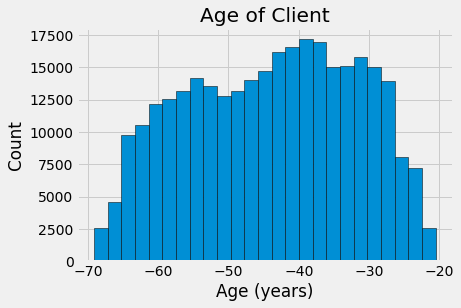

In [61]:
# Set the style of plots
plt.style.use('fivethirtyeight')

# Plot the distribution of ages in years
plt.hist(train['DAYS_BIRTH'] / 365, edgecolor = 'k', bins = 25)
plt.title('Age of Client')
plt.xlabel('Age (years)')
plt.ylabel('Count');

By itself, the distribution of age does not tell us much other than that there are no outliers as all the ages are reasonable. 

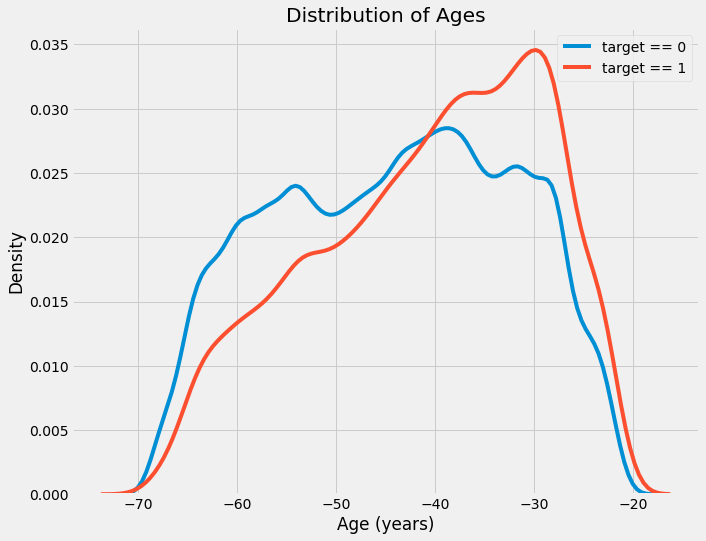

In [63]:
plt.figure(figsize = (10, 8))

# KDE plot of loans that were repaid on time
sns.kdeplot(train.loc[train['TARGET'] == 0, 'DAYS_BIRTH'] / 365, label = 'target == 0')

# KDE plot of loans which were not repaid on time
sns.kdeplot(train.loc[train['TARGET'] == 1, 'DAYS_BIRTH'] / 365, label = 'target == 1')

# Labeling of plot
plt.xlabel('Age (years)')
plt.ylabel('Density')
plt.title('Distribution of Ages');

The younger individu tend to less repay their loans, the 'label = 0' is kinf of letf skewed and the 'label = 1' is right skewed. Let's explore this more in depth.

In [67]:
age_data = train[['TARGET','DAYS_BIRTH']]
age_data['AGE_'] = age_data['DAYS_BIRTH'] / -365

In [68]:
age_data['AGE_'].describe()

count    307511.000000
mean         43.936973
std          11.956133
min          20.517808
25%          34.008219
50%          43.150685
75%          53.923288
max          69.120548
Name: AGE_, dtype: float64

In [71]:
age_data['AGE_BIN'] = pd.cut(age_data['AGE_'], bins = np.linspace(20,70, num = 11) )

In [72]:
age_data.head()

,TARGET,DAYS_BIRTH,AGE_,AGE_BIN
0,1,-9461,25.920548,"(25.0, 30.0]"
1,0,-16765,45.931507,"(45.0, 50.0]"
2,0,-19046,52.180822,"(50.0, 55.0]"
3,0,-19005,52.068493,"(50.0, 55.0]"
4,0,-19932,54.608219,"(50.0, 55.0]"


In [74]:
age_groups = age_data.groupby('AGE_BIN').mean()
age_groups

,TARGET,DAYS_BIRTH,AGE_
AGE_BIN,,,
"(20.0, 25.0]",0.123036,-8532.795625,23.377522
"(25.0, 30.0]",0.111436,-10155.219250,27.822518
"(30.0, 35.0]",0.102814,-11854.848377,32.479037
"(35.0, 40.0]",0.089414,-13707.908253,37.555913
"(40.0, 45.0]",0.078491,-15497.661233,42.459346
"(45.0, 50.0]",0.074171,-17323.900441,47.462741
"(50.0, 55.0]",0.066968,-19196.494791,52.593136
"(55.0, 60.0]",0.055314,-20984.262742,57.491131
"(60.0, 65.0]",0.052737,-22780.547460,62.412459


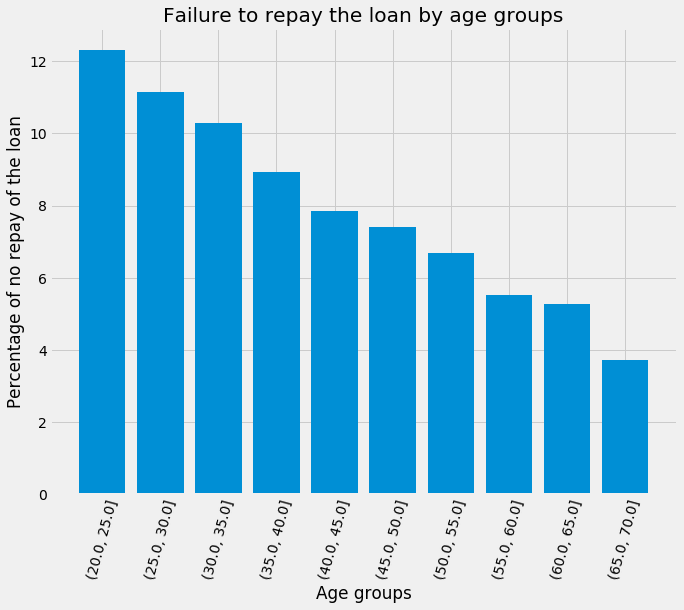

In [76]:
plt.figure(figsize = (10,8))

plt.bar(age_groups.index.astype(str), 100 * age_groups['TARGET'])

plt.xticks(rotation = 75)
plt.xlabel('Age groups')
plt.ylabel('Percentage of no repay of the loan')
plt.title('Failure to repay the loan by age groups');

We can see a clear trend, younger individus are more likely to not repay the loan.

This is information that could be directly used by the bank: because younger clients are less likely to repay the loan, maybe they should be provided with more guidance or financial planning tips. This does not mean the bank should discriminate against younger clients, but it would be smart to take precautionary measures to help younger clients pay on time.

**Exterior sources**

The 3 variables with the strongest negative correlations with the target are EXT_SOURCE_1, EXT_SOURCE_2, and EXT_SOURCE_3. 

Let's  take a look at these variables.

First, we can show the correlations of the EXT_SOURCE features with the target and with each other.

In [77]:
corr_ext = train[['TARGET' , 'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_BIRTH']]

corr = corr_ext.corr()

corr

,TARGET,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,DAYS_BIRTH
TARGET,1.000000,-0.155317,-0.160472,-0.178919,0.078239
EXT_SOURCE_1,-0.155317,1.000000,0.213982,0.186846,-0.600610
EXT_SOURCE_2,-0.160472,0.213982,1.000000,0.109167,-0.091996
EXT_SOURCE_3,-0.178919,0.186846,0.109167,1.000000,-0.205478
DAYS_BIRTH,0.078239,-0.600610,-0.091996,-0.205478,1.000000


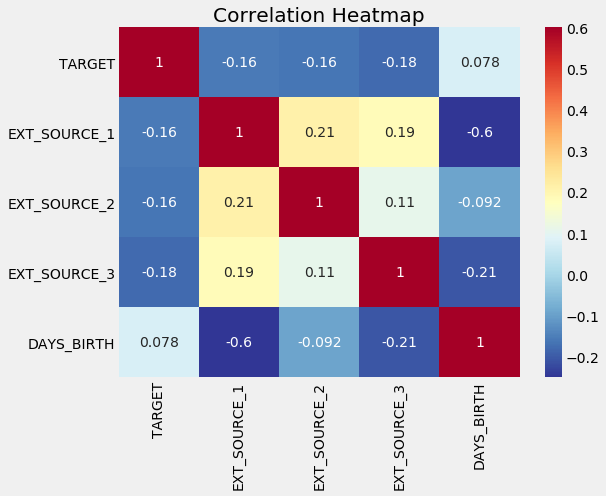

In [78]:
plt.figure(figsize = (8, 6))

# Heatmap of correlations
sns.heatmap(corr, cmap = plt.cm.RdYlBu_r, vmin = -0.25, annot = True, vmax = 0.6)
plt.title('Correlation Heatmap');

All three EXT_SOURCE features have negative correlations with the target, indicating that as the value of the EXT_SOURCE increases, the client is more likely to repay the loan. 

<a id="4"></a> <br>
## Feature Engineering

This represents one of the patterns in machine learning: feature engineering has a greater return on investment than model building and hyperparameter tuning. As Andrew Ng is fond of saying: "applied machine learning is basically feature engineering."

Feature engineering refers to a geneal process and can involve both feature construction: adding new features from the existing data, and feature selection: choosing only the most important features or other methods of dimensionality reduction. There are many techniques we can use to both create features and select features.

For now, we will focus on :

`Polynomial features`

`Domain knowledge features`

**Polynomial features**

One simple feature construction method is called polynomial features. In this method, we make features that are powers of existing features as well as interaction terms between existing features.
 In other words, while two variables by themselves may not have a strong influence on the target, combining them together into a single interaction variable might show a relationship with the target. Interaction terms are commonly used in statistical models to capture the effects of multiple variables.
 
In the following code, we create polynomial features using the EXT_SOURCE variables and the DAYS_BIRTH variable. 

We need to be careful to not create to many of them at the risk of running into overfitting.

In [267]:
poly_feat = train[['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_BIRTH', 'TARGET']]
poly_feat_test = test[['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_BIRTH']]

# use imputer for missing values
imputer = SimpleImputer(strategy = 'median')

poly_target = poly_feat['TARGET']
poly_feat = poly_feat.drop(columns = ['TARGET'])

poly_feat = imputer.fit_transform(poly_feat)
poly_feat_test = imputer.transform(poly_feat_test)

#polynomial transformations
poly_transformer = PolynomialFeatures(degree = 3)

poly_feat = poly_transformer.fit_transform(poly_feat)
poly_feat_test = poly_transformer.transform(poly_feat_test)

print('Polynomial features shapes :', poly_feat.shape)
print('Polynomial features shapes:' , poly_feat_test.shape)

Polynomial features shapes : (307511, 35)
Polynomial features shapes: (48744, 35)


This creates a considerable number of new features. To get the names we have to use the polynomial features get_feature_names method.

In [90]:
poly_transformer.get_feature_names(input_features = ['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_BIRTH'])[:15]

['1',
 'EXT_SOURCE_1',
 'EXT_SOURCE_2',
 'EXT_SOURCE_3',
 'DAYS_BIRTH',
 'EXT_SOURCE_1^2',
 'EXT_SOURCE_1 EXT_SOURCE_2',
 'EXT_SOURCE_1 EXT_SOURCE_3',
 'EXT_SOURCE_1 DAYS_BIRTH',
 'EXT_SOURCE_2^2',
 'EXT_SOURCE_2 EXT_SOURCE_3',
 'EXT_SOURCE_2 DAYS_BIRTH',
 'EXT_SOURCE_3^2',
 'EXT_SOURCE_3 DAYS_BIRTH',
 'DAYS_BIRTH^2']

There are 35 features with individual features raised to powers up to degree 3 and interaction terms. Now, we can see whether any of these new features are correlated with the target.

In [93]:
poly_feat = pd.DataFrame(poly_feat, columns = poly_transformer.get_feature_names(['EXT_SOURCE_1', 'EXT_SOURCE_2', 
                                                                           'EXT_SOURCE_3', 'DAYS_BIRTH']))

poly_feat['TARGET'] = poly_target

poly_corr = poly_feat.corr()['TARGET'].sort_values()

print(poly_corr.tail())
print(poly_corr.head(10))

EXT_SOURCE_1 EXT_SOURCE_2 DAYS_BIRTH    0.155891
EXT_SOURCE_2 DAYS_BIRTH                 0.156873
EXT_SOURCE_2 EXT_SOURCE_3 DAYS_BIRTH    0.181283
TARGET                                  1.000000
1                                            NaN
Name: TARGET, dtype: float64
EXT_SOURCE_2 EXT_SOURCE_3                -0.193939
EXT_SOURCE_1 EXT_SOURCE_2 EXT_SOURCE_3   -0.189605
EXT_SOURCE_2^2 EXT_SOURCE_3              -0.176428
EXT_SOURCE_2 EXT_SOURCE_3^2              -0.172282
EXT_SOURCE_1 EXT_SOURCE_2                -0.166625
EXT_SOURCE_1 EXT_SOURCE_3                -0.164065
EXT_SOURCE_2                             -0.160295
EXT_SOURCE_1 EXT_SOURCE_2^2              -0.156867
EXT_SOURCE_3                             -0.155892
EXT_SOURCE_1 EXT_SOURCE_3^2              -0.150822
Name: TARGET, dtype: float64


Several of the new variables have a greater (in terms of absolute magnitude) correlation with the target than the original features. When we build machine learning models, we can try with and without these features to determine if they actually help the model learn.
We will add these features to a copy of the training and testing data and then evaluate models with and without the features. Many times in machine learning, the only way to know if an approach will work is to try it out!

In [96]:
# Put test features into dataframe
poly_feat_test = pd.DataFrame(poly_feat_test, 
                                  columns = poly_transformer.get_feature_names(['EXT_SOURCE_1', 'EXT_SOURCE_2', 
                                                                                'EXT_SOURCE_3', 'DAYS_BIRTH']))

# Merge polynomial features into training dataframe
poly_feat['SK_ID_CURR'] = train['SK_ID_CURR']
train_poly = train.merge(poly_feat, on = 'SK_ID_CURR', how = 'left')

# Merge polynomial features into testing dataframe
poly_feat_test['SK_ID_CURR'] = test['SK_ID_CURR']
test_poly = test.merge(poly_feat_test, on = 'SK_ID_CURR', how = 'left')

train_poly, test_poly = train_poly.align(test_poly, join = 'inner', axis = 1)

print('Training polynomial data shapes :', train_poly.shape)
print('Testing polynomial data shapes :', test_poly.shape)

Training polynomial data shapes : (307511, 274)
Testing polynomial data shapes : (48744, 274)


**Domain Knowledge Features**

Here I'm going to use five features that were inspired by [this script](https://www.kaggle.com/jsaguiar/updated-0-792-lb-lightgbm-with-simple-features) by Aguiar:

- `CREDIT_INCOME_PERCENT`: the percentage of the credit amount relative to a client's income
-  `ANNUITY_INCOME_PERCENT`: the percentage of the loan annuity relative to a client's income
-  `CREDIT_TERM`:  the length of the payment in months (since the annuity is the monthly amount due
-  `DAYS_EMPLOYED_PERCENT`: the percentage of the days employed relative to the client's age

In [100]:
train_domain = train.copy()
test_domain = test.copy()

#train
train_domain['CREDIT_INCOME_PERCENT'] = train_domain['AMT_CREDIT'] / train_domain['AMT_INCOME_TOTAL']
train_domain['ANNUITY_INCOME_PERCENT'] = train_domain['AMT_ANNUITY'] / train_domain['AMT_INCOME_TOTAL']
train_domain['CREDIT_TERM'] = train_domain['AMT_ANNUITY'] / train_domain['AMT_CREDIT']
train_domain['DAYS_EMPLOYED_PERCENT'] = train_domain['DAYS_EMPLOYED'] / train_domain['DAYS_BIRTH']

#test
test_domain['CREDIT_INCOME_PERCENT'] = test_domain['AMT_CREDIT'] / test_domain['AMT_INCOME_TOTAL']
test_domain['ANNUITY_INCOME_PERCENT'] = test_domain['AMT_ANNUITY'] / test_domain['AMT_INCOME_TOTAL']
test_domain['CREDIT_TERM'] = test_domain['AMT_ANNUITY'] / test_domain['AMT_CREDIT']
test_domain['DAYS_EMPLOYED_PERCENT'] = test_domain['DAYS_EMPLOYED'] / test_domain['DAYS_BIRTH']

In [145]:
train_domain.drop(columns = ['TARGET'], inplace = True)

<a id="5"></a> <br>
## Implementing our models

**Logistic Regression Implementation**

In [157]:
#drop the target
df_train = train.drop(columns = ['TARGET'])

#feature = list(train.columns)

## Copy of the testing data
df_test = test.copy()

imputer = SimpleImputer(strategy = 'median')

scaler = MinMaxScaler(feature_range = (0,1))

df_train = imputer.fit_transform(df_train)
df_test = imputer.transform(test)

df_train = scaler.fit_transform(df_train)
df_test = scaler.transform(df_test)

print('Training data shape: ', train.shape)
print('Testing data shape: ', test.shape)

Training data shape:  (307511, 240)
Testing data shape:  (48744, 239)


The only change we will make from the default model settings is to lower the regularization parameter, C, which controls the amount of overfitting (a lower value should decrease overfitting). This will get us slightly better results than the default LogisticRegression, but it still will set a low bar for any future models.

In [158]:
LR = LogisticRegression(C = 0.0001).fit(df_train, labels)

 The first column is the probability of the target being 0 and the second column is the probability of the target being 1 (so for a single row, the two columns must sum to 1). We want the probability the loan is not repaid, so we will select the second column.

In [166]:
test_id = test['SK_ID_CURR']

# Make predictions
# Make sure to select the second column only
LR_pred = LR.predict_proba(df_test)[:, 1]

The predictions must be in the format shown in the sample_submission.csv file, where there are only two columns: SK_ID_CURR and TARGET. We will create a dataframe in this format from the test set and the predictions called submit.

In [167]:
LR = pd.DataFrame()
LR['SK_ID_CURR'] = test_id
LR['TARGET'] = LR_pred
LR.to_csv("LR.csv", index=False)
LR.head()

,SK_ID_CURR,TARGET
0,100001,0.065187
1,100005,0.117033
2,100013,0.067768
3,100028,0.070727
4,100038,0.118041


The predictions represent a probability between 0 and 1 that the loan will not be repaid. If we were using these predictions to classify applicants, we could set a probability threshold for determining that a loan is risky.

Our first submission to Kaggle with our baseline Logistic Regression is `0.68292`.Not bad but not great either. It's good for a first model nonetheless.

**Random Forest implementation**

In [168]:
RF = RandomForestClassifier(n_estimators = 100, random_state = 50, verbose = 1, n_jobs = -1).fit(df_train, labels)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   29.3s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  1.4min finished


In [129]:
df_train1 = train.drop(columns = ['TARGET'])

features_importances_values = RF.feature_importances_

features_importances = pd.DataFrame({'features' : list(df_train1.columns), 'importances' : features_importances_values})

features_importances.sort_values(by = 'importances', ascending = False).head(15)

,features,importances
32,EXT_SOURCE_2,0.049875
33,EXT_SOURCE_3,0.046725
13,DAYS_ID_PUBLISH,0.032073
10,DAYS_BIRTH,0.031941
12,DAYS_REGISTRATION,0.031317
0,SK_ID_CURR,0.030335
11,DAYS_EMPLOYED,0.029663
7,AMT_ANNUITY,0.028913
81,DAYS_LAST_PHONE_CHANGE,0.028355
6,AMT_CREDIT,0.027407


As expected, the most important features are those dealing with EXT_SOURCE and DAYS_BIRTH. We see that there are only a handful of features with a significant importance to the model, which suggests we may be able to drop many of the features without a decrease in performance (and we may even see an increase in performance.) Feature importances are not the most sophisticated method to interpret a model or perform dimensionality reduction, but they let us start to understand what factors our model takes into account when it makes predictions.

In [169]:
# Make predictions on the test data
predictions = RF.predict_proba(df_test)[:, 1]

RF = pd.DataFrame()
RF['SK_ID_CURR'] = test_id
RF['TARGET'] = predictions
RF.to_csv("RF1.csv", index=False)

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.3s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.9s finished


This time, we obtained `0.69144`. A improvement, even slightly, is always nice ! 

**Make Random Forest Predictions using Engineered Features**

The only way to see if the Polynomial Features and Domain knowledge improved the model is to train a test a model on these features! We can then compare the submission performance to that for the model without these features to gauge the effect of our feature engineering.

In [170]:
Imputer = SimpleImputer(strategy = 'median')

train_poly_feat = Imputer.fit_transform(train_poly)
test_poly_feat = Imputer.transform(test_poly)

scaler = MinMaxScaler(feature_range = (0, 1))

train_poly_feat = scaler.fit_transform(train_poly_feat)
test_poly_feat = scaler.transform(test_poly_feat)

RFpoly = RandomForestClassifier(n_estimators = 100, random_state = 50, verbose = 1, n_jobs = -1).fit(train_poly_feat, labels)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   42.8s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  1.9min finished


In [171]:
# Make predictions on the test data
predictions = RFpoly.predict_proba(test_poly_feat)[:, 1]

RFengi = pd.DataFrame()
RFengi['SK_ID_CURR'] = test_id
RFengi['TARGET'] = predictions
RFengi.to_csv("RF2.csv", index=False)

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.8s finished


This time, we obtained `0.69181` after we submitted to Kaggle. Slightly better than without engineered features.

In [139]:
#feat importances
features_importances_values = RFpoly.feature_importances_

features_importances = pd.DataFrame({'features' : list(train_poly.columns), 'importances' : features_importances_values})

features_importances.sort_values(by = 'importances', ascending = False).head(15)

,features,importances
259,EXT_SOURCE_1 EXT_SOURCE_2 EXT_SOURCE_3,0.019224
267,EXT_SOURCE_2 EXT_SOURCE_3^2,0.017571
249,EXT_SOURCE_2 EXT_SOURCE_3,0.017266
265,EXT_SOURCE_2^2 EXT_SOURCE_3,0.017263
13,DAYS_ID_PUBLISH,0.016957
268,EXT_SOURCE_2 EXT_SOURCE_3 DAYS_BIRTH,0.016791
12,DAYS_REGISTRATION,0.016739
0,SK_ID_CURR,0.016539
11,DAYS_EMPLOYED,0.015804
7,AMT_ANNUITY,0.015602


As we can see, we had the right idea to add some polynomial feature, they are strongly represented into the most importance feature in this model.

**Make Random Forest Predictions using Domain Features**

In [172]:
Imputer = SimpleImputer(strategy = 'median')

train_domain_feat = Imputer.fit_transform(train_domain)
test_domain_feat = Imputer.transform(test_domain)

scaler = MinMaxScaler(feature_range = (0, 1))

train_domain_feat = scaler.fit_transform(train_domain_feat)
test_domain_feat = scaler.transform(test_domain_feat)

RFdomain = RandomForestClassifier(n_estimators = 100, random_state = 50, verbose = 1, n_jobs = -1).fit(train_domain_feat, labels)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   32.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  1.4min finished


In [173]:
# Make predictions on the test data
predictions = RFdomain.predict_proba(test_domain_feat)[:, 1]

RFdom = pd.DataFrame()
RFdom['SK_ID_CURR'] = test_id
RFdom['TARGET'] = predictions
RFdom.to_csv("RF3.csv", index=False)

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.3s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.9s finished


This time we obtained our best score so far : `0.70795` ! 

In [148]:
#feat importances
features_importances_values = RFdomain.feature_importances_

features_importances = pd.DataFrame({'features' : list(train_domain.columns), 'importances' : features_importances_values})

features_importances.sort_values(by = 'importances', ascending = False).head(15)

,features,importances
32,EXT_SOURCE_2,0.045253
33,EXT_SOURCE_3,0.043498
10,DAYS_BIRTH,0.028594
13,DAYS_ID_PUBLISH,0.028288
12,DAYS_REGISTRATION,0.027512
241,CREDIT_TERM,0.027045
0,SK_ID_CURR,0.026504
240,ANNUITY_INCOME_PERCENT,0.026217
239,CREDIT_INCOME_PERCENT,0.025256
11,DAYS_EMPLOYED,0.024888


We see that all four of our hand-engineered features made it into the top 15 most important features ! 

<a id="6"></a> <br>
## Quick check out on others machine learning models

Before we dive into more serious stuff, like include more informations from the other dataframe (here we just used the `application` data), let's quickly see which machine learning models suits the data the most. Let's try for :

- Basic application data
- Application data with polynomial feature
- Application data with domains features

**Basic application data**

In [151]:
KFold = StratifiedKFold(n_splits=3, random_state=42)
scores = {}

def score_model(model):
    return cross_val_score(model, df_train, labels, scoring='roc_auc', cv = KFold)

#.todense()


# time: 10s
scores['tree'] = score_model(tree.DecisionTreeClassifier())

# time: 9s
scores['extra_tree'] = score_model(ensemble.ExtraTreesClassifier())

# time: 7s
scores['forest'] = score_model(ensemble.RandomForestClassifier())

# time: 33s
scores['ada_boost'] = score_model(ensemble.AdaBoostClassifier())

# time: 1min
scores['bagging'] = score_model(ensemble.BaggingClassifier())

# time: 2min30s
scores['grad_boost'] = score_model(ensemble.GradientBoostingClassifier())

# time: 49s
scores['ridge'] = score_model(linear_model.RidgeClassifier())

# time: 4s
scores['passive'] = score_model(linear_model.PassiveAggressiveClassifier())

# time: 4s
scores['sgd'] = score_model(linear_model.SGDClassifier())

# time: 3s
#scores['gaussian'] = score_model(naive_bayes.GaussianNB())

# time: 4min
scores['xgboost'] = score_model(xgb.XGBClassifier())

scores['LightGBM'] = score_model(LGBMClassifier())

scores['LinearSVC'] = score_model(LinearSVC())

scores['LR'] = score_model(LogisticRegression())

In [152]:
# Print the scores 
model_scores = pd.DataFrame(scores).mean()
model_scores = model_scores.sort_values(ascending=False)
#model_scores.to_csv('model_scores.csv', index=False)
print('Model scores\n{}'.format(model_scores))

Model scores
LightGBM      0.749178
LinearSVC     0.745905
ridge         0.745343
LR            0.744266
xgboost       0.744079
ada_boost     0.742300
extra_tree    0.700039
sgd           0.697054
forest        0.682164
grad_boost    0.672814
passive       0.650388
bagging       0.584223
tree          0.510971
dtype: float64


**Application data with polynomial features**

In [153]:
KFold = StratifiedKFold(n_splits=3, random_state=42)
scores = {}

def score_model(model):
    return cross_val_score(model, train_poly_feat, labels, scoring='roc_auc', cv = KFold)

#.todense()


# time: 10s
scores['tree'] = score_model(tree.DecisionTreeClassifier())

# time: 9s
scores['extra_tree'] = score_model(ensemble.ExtraTreesClassifier())

# time: 7s
scores['forest'] = score_model(ensemble.RandomForestClassifier())

# time: 33s
scores['ada_boost'] = score_model(ensemble.AdaBoostClassifier())

# time: 1min
scores['bagging'] = score_model(ensemble.BaggingClassifier())

# time: 2min30s
scores['grad_boost'] = score_model(ensemble.GradientBoostingClassifier())

# time: 49s
scores['ridge'] = score_model(linear_model.RidgeClassifier())

# time: 4s
scores['passive'] = score_model(linear_model.PassiveAggressiveClassifier())

# time: 4s
scores['sgd'] = score_model(linear_model.SGDClassifier())

# time: 3s
#scores['gaussian'] = score_model(naive_bayes.GaussianNB())

# time: 4min
scores['xgboost'] = score_model(xgb.XGBClassifier())

scores['LightGBM'] = score_model(LGBMClassifier())

scores['LinearSVC'] = score_model(LinearSVC())

scores['LR'] = score_model(LogisticRegression())

In [154]:
# Print the scores 
model_scores = pd.DataFrame(scores).mean()
model_scores = model_scores.sort_values(ascending=False)
#model_scores.to_csv('model_scores.csv', index=False)
print('Model scores\n{}'.format(model_scores))

Model scores
LinearSVC     0.746213
LightGBM      0.745444
ridge         0.745131
LR            0.744833
ada_boost     0.743815
xgboost       0.738938
extra_tree    0.713612
sgd           0.700716
forest        0.690752
passive       0.687336
grad_boost    0.685727
bagging       0.577397
tree          0.525233
dtype: float64


**Application data with domains features**

In [155]:
KFold = StratifiedKFold(n_splits=3, random_state=42)
scores = {}

def score_model(model):
    return cross_val_score(model, train_domain_feat, labels, scoring='roc_auc', cv = KFold)

#.todense()


# time: 10s
scores['tree'] = score_model(tree.DecisionTreeClassifier())

# time: 9s
scores['extra_tree'] = score_model(ensemble.ExtraTreesClassifier())

# time: 7s
scores['forest'] = score_model(ensemble.RandomForestClassifier())

# time: 33s
scores['ada_boost'] = score_model(ensemble.AdaBoostClassifier())

# time: 1min
scores['bagging'] = score_model(ensemble.BaggingClassifier())

# time: 2min30s
scores['grad_boost'] = score_model(ensemble.GradientBoostingClassifier())

# time: 49s
scores['ridge'] = score_model(linear_model.RidgeClassifier())

# time: 4s
scores['passive'] = score_model(linear_model.PassiveAggressiveClassifier())

# time: 4s
scores['sgd'] = score_model(linear_model.SGDClassifier())

# time: 3s
#scores['gaussian'] = score_model(naive_bayes.GaussianNB())

# time: 4min
scores['xgboost'] = score_model(xgb.XGBClassifier())

scores['LightGBM'] = score_model(LGBMClassifier())

scores['LinearSVC'] = score_model(LinearSVC())

scores['LR'] = score_model(LogisticRegression())

In [156]:
# Print the scores 
model_scores = pd.DataFrame(scores).mean()
model_scores = model_scores.sort_values(ascending=False)
#model_scores.to_csv('model_scores.csv', index=False)
print('Model scores\n{}'.format(model_scores))

Model scores
LightGBM      0.753783
LinearSVC     0.747231
ada_boost     0.747216
ridge         0.746607
LR            0.745770
xgboost       0.744111
extra_tree    0.703320
grad_boost    0.697086
sgd           0.691243
forest        0.681549
passive       0.674620
bagging       0.593353
tree          0.513983
dtype: float64


LightGBM seems the more efficient, first twice, and second once. Let's quickly try to submit to Kaggle with this model.

**Submission to Kaggle**

In [176]:
LGBM = LGBMClassifier().fit(train_domain_feat, labels)

# Make predictions on the test data
predictions = LGBM.predict_proba(test_domain_feat)[:, 1]

LGBM = pd.DataFrame()
LGBM['SK_ID_CURR'] = test_id
LGBM['TARGET'] = predictions
LGBM.to_csv("LGBM.csv", index=False)

Nice pick ! Here, we obtained `0.75962` with our LGBM submission to Kaggle ! Really huge improvement. LGBM seems the most suited to this kind of data. 

<a id="7"></a> <br>
## Manual feature engineering

Now, let's dive into more data. The best model we made from `application` achieved a score on the leaderboard around 0.76. 

In order to better this score, we will have to include more information from the other dataframes. Here, we will look at using information from the bureau and bureau_balance data. The definitions of these data files are:

`bureau`: information about client's previous loans with other financial institutions reported to Home Credit. Each previous loan has its own row.
`bureau_balance`: monthly information about the previous loans. Each month has its own row.

We already did some manual features engineering earlier when we created those variables :

- `CREDIT_INCOME_PERCENT`: the percentage of the credit amount relative to a client's income
-  `ANNUITY_INCOME_PERCENT`: the percentage of the loan annuity relative to a client's income
-  `CREDIT_TERM`:  the length of the payment in months (since the annuity is the monthly amount due
-  `DAYS_EMPLOYED_PERCENT`: the percentage of the days employed relative to the client's age

But here, we will see more in depth how to deal with that.

In [276]:
bureau = pd.read_csv('bureau.csv')
print('Data bureau shape :', bureau.shape)
bureau.head()

Data bureau shape : (1716428, 17)


,SK_ID_CURR,SK_ID_BUREAU,CREDIT_ACTIVE,CREDIT_CURRENCY,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,CREDIT_TYPE,DAYS_CREDIT_UPDATE,AMT_ANNUITY
0,215354,5714462,Closed,currency 1,-497,0,-153.0,-153.0,NaN,0,91323.0,0.0,NaN,0.0,Consumer credit,-131,NaN
1,215354,5714463,Active,currency 1,-208,0,1075.0,NaN,NaN,0,225000.0,171342.0,NaN,0.0,Credit card,-20,NaN
2,215354,5714464,Active,currency 1,-203,0,528.0,NaN,NaN,0,464323.5,NaN,NaN,0.0,Consumer credit,-16,NaN
3,215354,5714465,Active,currency 1,-203,0,NaN,NaN,NaN,0,90000.0,NaN,NaN,0.0,Credit card,-16,NaN
4,215354,5714466,Active,currency 1,-629,0,1197.0,NaN,77674.5,0,2700000.0,NaN,NaN,0.0,Consumer credit,-21,NaN


**Example: Counts of a client's previous loans**

In [277]:
#previous_loan_count = 

bureau.groupby('SK_ID_CURR', as_index = False)['AMT_CREDIT_SUM'].sum()

,SK_ID_CURR,AMT_CREDIT_SUM
0,100001,1453365.000
1,100002,865055.565
2,100003,1017400.500
3,100004,189037.800
4,100005,657126.000
...,...,...
305806,456249,3693858.660
305807,456250,3086459.550
305808,456253,3960000.000
305809,456254,45000.000


In [278]:
previous_loan_count = bureau.groupby('SK_ID_CURR', as_index = False)['SK_ID_BUREAU'].count().rename(columns = {'SK_ID_BUREAU' : 'previous_loan_counts'})

previous_loan_count.head()

,SK_ID_CURR,previous_loan_counts
0,100001,7
1,100002,8
2,100003,4
3,100004,2
4,100005,3


In [279]:
train = pd.read_csv('application_train.csv')

train = train.merge(previous_loan_count, on = 'SK_ID_CURR', how = 'left')

train['previous_loan_counts'].fillna(0, inplace = True)

train.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,previous_loan_counts
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0,8.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,4.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,2.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,0.0
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


**Usefulness of New Variable**

To see if our variable is useful, we can calculate the Pearson Correlation Coefficient (r-value) between this variable and the target. This measures the strength of a linear relationship between two variables and ranges from -1 (perfectly negatively linear) to +1 (perfectly positively linear). The r-value is not best measure of the "usefulness" of a new variable, but it can give a first approximation of whether a variable will be helpful to a machine learning model. So let's do this :

In [193]:
def corr(var_name, df):
    corr = df['TARGET'].corr(df[var_name])
    
    median_repaid = df.loc[df['TARGET'] == 0, var_name].median()
    median_not_repaid = df.loc[df['TARGET'] == 1, var_name].median()
    
    plt.figure(figsize = (10,8))
    sns.kdeplot(df.loc[df['TARGET'] == 0, var_name], label = 'target = 0')
    sns.kdeplot(df.loc[df['TARGET'] == 1, var_name], label = 'target = 1')
    plt.xlabel(var_name)
    plt.ylabel('Density')
    plt.title('Density with TARGET')
    plt.legend();
    
    print('The correlation between {} and the TARGET is {}'.format(var_name, corr))
    print('')
    print('The median value for loan that was repaid is :', median_repaid)
    print('')
    print('The median value for loan that was not repaid is :', median_not_repaid)
    
#print('train data has {} row and {} columns'.format(train.shape[0], train.shape[1]))

The correlation between previous_loan_counts and the TARGET is -0.010019715670684074

The median value for loan that was repaid is : 4.0

The median value for loan that was not repaid is : 3.0


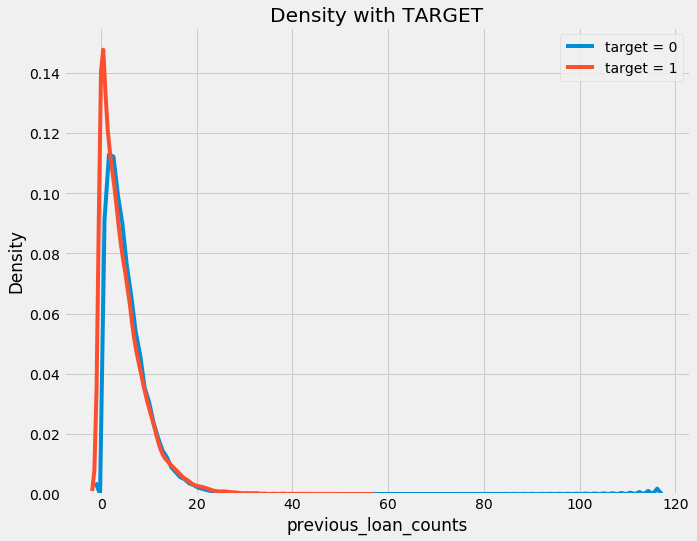

In [194]:
corr('previous_loan_counts', train)

From this it's difficult to tell if this variable will be important. The correlation coefficient is extremely weak and there is almost no noticeable difference in the distributions.

Let's move on to make a few more variables from the bureau dataframe. 

**Categorical Variables**

First we one-hot encode a dataframe with only the categorical columns (dtype == 'object').

In [280]:
categorical = pd.get_dummies(bureau.select_dtypes('object'))
categorical['SK_ID_CURR'] = bureau['SK_ID_CURR']

categorical.head()

,CREDIT_ACTIVE_Active,CREDIT_ACTIVE_Bad debt,CREDIT_ACTIVE_Closed,CREDIT_ACTIVE_Sold,CREDIT_CURRENCY_currency 1,CREDIT_CURRENCY_currency 2,CREDIT_CURRENCY_currency 3,CREDIT_CURRENCY_currency 4,CREDIT_TYPE_Another type of loan,CREDIT_TYPE_Car loan,...,CREDIT_TYPE_Loan for business development,CREDIT_TYPE_Loan for purchase of shares (margin lending),CREDIT_TYPE_Loan for the purchase of equipment,CREDIT_TYPE_Loan for working capital replenishment,CREDIT_TYPE_Microloan,CREDIT_TYPE_Mobile operator loan,CREDIT_TYPE_Mortgage,CREDIT_TYPE_Real estate loan,CREDIT_TYPE_Unknown type of loan,SK_ID_CURR
0,0,0,1,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,215354
1,1,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,215354
2,1,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,215354
3,1,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,215354
4,1,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,215354


In [281]:
categorical_grouped = categorical.groupby('SK_ID_CURR').agg(['sum', 'mean'])
categorical_grouped.head()

CREDIT_ACTIVE_Active           CREDIT_ACTIVE_Bad debt       \
                            sum      mean                    sum mean   
SK_ID_CURR                                                              
100001                        3  0.428571                      0  0.0   
100002                        2  0.250000                      0  0.0   
100003                        1  0.250000                      0  0.0   
100004                        0  0.000000                      0  0.0   
100005                        2  0.666667                      0  0.0   

           CREDIT_ACTIVE_Closed           CREDIT_ACTIVE_Sold       \
                            sum      mean                sum mean   
SK_ID_CURR                                                          
100001                        4  0.571429                  0  0.0   
100002                        6  0.750000                  0  0.0   
100003                        3  0.750000                  0  0.0   
100004                        2  1.000000                  0  0.0   
100005                        1  0.333333                  0  0.0   

           CREDIT_CURRENCY_currency 1       ... CREDIT_TYPE_Microloan       \
                                  sum mean  ...                   sum mean   
SK_ID_CURR                                  ...                              
100001                              7  1.0  ...                     0  0.0   
100002                              8  1.0  ...                     0  0.0   
100003                              4  1.0  ...                     0  0.0   
100004                              2  1.0  ...                     0  0.0   
100005                              3  1.0  ...                     0  0.0   

           CREDIT_TYPE_Mobile operator loan      CREDIT_TYPE_Mortgage       \
                                        sum mean                  sum mean   
SK_ID_CURR                                                                   
100001                                    0  0.0                    0  0.0   
100002                                    0  0.0                    0  0.0   
100003                                    0  0.0                    0  0.0   
100004                                    0  0.0                    0  0.0   
100005                                    0  0.0                    0  0.0   

           CREDIT_TYPE_Real estate loan      CREDIT_TYPE_Unknown type of loan  \
                                    sum mean                              sum   
SK_ID_CURR                                                                      
100001                                0  0.0                                0   
100002                                0  0.0                                0   
100003                                0  0.0                                0   
100004                                0  0.0                                0   
100005                                0  0.0                                0   

                 
           mean  
SK_ID_CURR       
100001      0.0  
100002      0.0  
100003      0.0  
100004      0.0  
100005      0.0  

[5 rows x 46 columns]

The sum columns represent the count of that category for the associated client and the mean represents the normalized count.

Let's rename the columns :

In [282]:
group_var = 'SK_ID_CURR'

# Need to create new column names
columns = []

# Iterate through the variables names
for var in categorical_grouped.columns.levels[0]:
    # Skip the grouping variable
    if var != group_var:
        # Iterate through the stat names
        for stat in ['count', 'count_norm']:
            # Make a new column name for the variable and stat
            columns.append('%s_%s' % (var, stat))

#  Rename the columns
categorical_grouped.columns = columns

categorical_grouped.head()

,CREDIT_ACTIVE_Active_count,CREDIT_ACTIVE_Active_count_norm,CREDIT_ACTIVE_Bad debt_count,CREDIT_ACTIVE_Bad debt_count_norm,CREDIT_ACTIVE_Closed_count,CREDIT_ACTIVE_Closed_count_norm,CREDIT_ACTIVE_Sold_count,CREDIT_ACTIVE_Sold_count_norm,CREDIT_CURRENCY_currency 1_count,CREDIT_CURRENCY_currency 1_count_norm,...,CREDIT_TYPE_Microloan_count,CREDIT_TYPE_Microloan_count_norm,CREDIT_TYPE_Mobile operator loan_count,CREDIT_TYPE_Mobile operator loan_count_norm,CREDIT_TYPE_Mortgage_count,CREDIT_TYPE_Mortgage_count_norm,CREDIT_TYPE_Real estate loan_count,CREDIT_TYPE_Real estate loan_count_norm,CREDIT_TYPE_Unknown type of loan_count,CREDIT_TYPE_Unknown type of loan_count_norm
SK_ID_CURR,,,,,,,,,,,,,,,,,,,,,
100001,3,0.428571,0,0.0,4,0.571429,0,0.0,7,1.0,...,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0
100002,2,0.250000,0,0.0,6,0.750000,0,0.0,8,1.0,...,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0
100003,1,0.250000,0,0.0,3,0.750000,0,0.0,4,1.0,...,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0
100004,0,0.000000,0,0.0,2,1.000000,0,0.0,2,1.0,...,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0
100005,2,0.666667,0,0.0,1,0.333333,0,0.0,3,1.0,...,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0


Let's merge this :

In [283]:
train = train.merge(categorical_grouped, on = 'SK_ID_CURR', how = 'left')
train.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,CREDIT_TYPE_Microloan_count,CREDIT_TYPE_Microloan_count_norm,CREDIT_TYPE_Mobile operator loan_count,CREDIT_TYPE_Mobile operator loan_count_norm,CREDIT_TYPE_Mortgage_count,CREDIT_TYPE_Mortgage_count_norm,CREDIT_TYPE_Real estate loan_count,CREDIT_TYPE_Real estate loan_count_norm,CREDIT_TYPE_Unknown type of loan_count,CREDIT_TYPE_Unknown type of loan_count_norm
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [284]:
train.shape

(307511, 169)

Let's write a function to wrap up all of this, in case we need id for futur work :

In [215]:
def count_categorical(df, group_var, df_name):
    categorical = pd.get_dummies(df.select_dtypes('object'))
    categorical[group_var] = df[group_var] 
    
    categorical = categorical.groupby(group_var).agg(['sum', 'mean'])
    
    columns = []

    for var in categorical.columns.levels[0]:
        for stat in ['count', 'count_norm']:
            # Make a new column name for the variable and stat
            columns.append('%s_%s' % (var, stat))

    categorical.columns = columns
    
    return categorical


In [216]:
bureau_counts = count_categorical(bureau, group_var = 'SK_ID_CURR', df_name = 'bureau')
bureau_counts.head()

,CREDIT_ACTIVE_Active_count,CREDIT_ACTIVE_Active_count_norm,CREDIT_ACTIVE_Bad debt_count,CREDIT_ACTIVE_Bad debt_count_norm,CREDIT_ACTIVE_Closed_count,CREDIT_ACTIVE_Closed_count_norm,CREDIT_ACTIVE_Sold_count,CREDIT_ACTIVE_Sold_count_norm,CREDIT_CURRENCY_currency 1_count,CREDIT_CURRENCY_currency 1_count_norm,...,CREDIT_TYPE_Microloan_count,CREDIT_TYPE_Microloan_count_norm,CREDIT_TYPE_Mobile operator loan_count,CREDIT_TYPE_Mobile operator loan_count_norm,CREDIT_TYPE_Mortgage_count,CREDIT_TYPE_Mortgage_count_norm,CREDIT_TYPE_Real estate loan_count,CREDIT_TYPE_Real estate loan_count_norm,CREDIT_TYPE_Unknown type of loan_count,CREDIT_TYPE_Unknown type of loan_count_norm
SK_ID_CURR,,,,,,,,,,,,,,,,,,,,,
100001,3,0.428571,0,0.0,4,0.571429,0,0.0,7,1.0,...,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0
100002,2,0.250000,0,0.0,6,0.750000,0,0.0,8,1.0,...,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0
100003,1,0.250000,0,0.0,3,0.750000,0,0.0,4,1.0,...,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0
100004,0,0.000000,0,0.0,2,1.000000,0,0.0,2,1.0,...,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0
100005,2,0.666667,0,0.0,1,0.333333,0,0.0,3,1.0,...,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0


That's sound about right !

**Aggregating Numeric Columns**

Let's do the same but with the numeric columns instead !

In [285]:
bureau_agg = bureau.drop(columns = ['SK_ID_BUREAU']).groupby('SK_ID_CURR', as_index = False).agg(['sum', 'mean', 'max', 'min', 'count']).reset_index()
bureau_agg.head()

SK_ID_CURR DAYS_CREDIT                               CREDIT_DAY_OVERDUE  \
                     sum         mean  max   min count                sum   
0     100001       -5145  -735.000000  -49 -1572     7                  0   
1     100002       -6992  -874.000000 -103 -1437     8                  0   
2     100003       -5603 -1400.750000 -606 -2586     4                  0   
3     100004       -1734  -867.000000 -408 -1326     2                  0   
4     100005        -572  -190.666667  -62  -373     3                  0   

                ... DAYS_CREDIT_UPDATE                               \
  mean max min  ...                sum        mean  max   min count   
0  0.0   0   0  ...               -652  -93.142857   -6  -155     7   
1  0.0   0   0  ...              -3999 -499.875000   -7 -1185     8   
2  0.0   0   0  ...              -3264 -816.000000  -43 -2131     4   
3  0.0   0   0  ...              -1064 -532.000000 -382  -682     2   
4  0.0   0   0  ...               -163  -54.333333  -11  -121     3   

  AMT_ANNUITY                                   
          sum         mean      max  min count  
0     24817.5  3545.357143  10822.5  0.0     7  
1         0.0     0.000000      0.0  0.0     7  
2         0.0          NaN      NaN  NaN     0  
3         0.0          NaN      NaN  NaN     0  
4      4261.5  1420.500000   4261.5  0.0     3  

[5 rows x 61 columns]

We need to rename all those columns for more clarity ! Multi-level index are confusing.

In [286]:
# List of column names
columns = ['SK_ID_CURR']

# Iterate through the variables names
for var in bureau_agg.columns.levels[0]:
    # Skip the id name
    if var != 'SK_ID_CURR':
        
        # Iterate through the stat names
        for stat in bureau_agg.columns.levels[1][:-1]:
            # Make a new column name for the variable and stat
            columns.append('bureau_%s_%s' % (var, stat))

In [287]:
# Assign the list of columns names as the dataframe column names
bureau_agg.columns = columns
bureau_agg.head()

,SK_ID_CURR,bureau_DAYS_CREDIT_sum,bureau_DAYS_CREDIT_mean,bureau_DAYS_CREDIT_max,bureau_DAYS_CREDIT_min,bureau_DAYS_CREDIT_count,bureau_CREDIT_DAY_OVERDUE_sum,bureau_CREDIT_DAY_OVERDUE_mean,bureau_CREDIT_DAY_OVERDUE_max,bureau_CREDIT_DAY_OVERDUE_min,...,bureau_DAYS_CREDIT_UPDATE_sum,bureau_DAYS_CREDIT_UPDATE_mean,bureau_DAYS_CREDIT_UPDATE_max,bureau_DAYS_CREDIT_UPDATE_min,bureau_DAYS_CREDIT_UPDATE_count,bureau_AMT_ANNUITY_sum,bureau_AMT_ANNUITY_mean,bureau_AMT_ANNUITY_max,bureau_AMT_ANNUITY_min,bureau_AMT_ANNUITY_count
0,100001,-5145,-735.000000,-49,-1572,7,0,0.0,0,0,...,-652,-93.142857,-6,-155,7,24817.5,3545.357143,10822.5,0.0,7
1,100002,-6992,-874.000000,-103,-1437,8,0,0.0,0,0,...,-3999,-499.875000,-7,-1185,8,0.0,0.000000,0.0,0.0,7
2,100003,-5603,-1400.750000,-606,-2586,4,0,0.0,0,0,...,-3264,-816.000000,-43,-2131,4,0.0,NaN,NaN,NaN,0
3,100004,-1734,-867.000000,-408,-1326,2,0,0.0,0,0,...,-1064,-532.000000,-382,-682,2,0.0,NaN,NaN,NaN,0
4,100005,-572,-190.666667,-62,-373,3,0,0.0,0,0,...,-163,-54.333333,-11,-121,3,4261.5,1420.500000,4261.5,0.0,3


Let's regroup with the main dataframe train

In [288]:
train = train.merge(bureau_agg, on = 'SK_ID_CURR', how = 'left')
print('train shape :', train.shape)
train.head()

train shape : (307511, 229)


,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,bureau_DAYS_CREDIT_UPDATE_sum,bureau_DAYS_CREDIT_UPDATE_mean,bureau_DAYS_CREDIT_UPDATE_max,bureau_DAYS_CREDIT_UPDATE_min,bureau_DAYS_CREDIT_UPDATE_count,bureau_AMT_ANNUITY_sum,bureau_AMT_ANNUITY_mean,bureau_AMT_ANNUITY_max,bureau_AMT_ANNUITY_min,bureau_AMT_ANNUITY_count
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,-3999.0,-499.875,-7.0,-1185.0,8.0,0.0,0.0,0.0,0.0,7.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,-3264.0,-816.000,-43.0,-2131.0,4.0,0.0,NaN,NaN,NaN,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,-1064.0,-532.000,-382.0,-682.0,2.0,0.0,NaN,NaN,NaN,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,-783.0,-783.000,-783.0,-783.0,1.0,0.0,NaN,NaN,NaN,0.0


Again let's wrap up all of this with a function :

In [228]:
def agg_numeric(df, group_var, df_name):
    for col in df:
        if col != group_var and 'SK_ID' in col:
            df = df.drop(columns = col)
            
    group_ids = df[group_var]
    numeric_df = df.select_dtypes('number')
    numeric_df[group_var] = group_ids

    # Group by the specified variable and calculate the statistics
    agg = numeric_df.groupby(group_var).agg(['count', 'mean', 'max', 'min', 'sum']).reset_index()

    # Need to create new column names
    columns = [group_var]

    # Iterate through the variables names
    for var in agg.columns.levels[0]:
        # Skip the grouping variable
        if var != group_var:
            # Iterate through the stat names
            for stat in agg.columns.levels[1][:-1]:
                # Make a new column name for the variable and stat
                columns.append('%s_%s_%s' % (df_name, var, stat))

    agg.columns = columns
    return agg

In [229]:
bureau_agg_new = agg_numeric(bureau.drop(columns = ['SK_ID_BUREAU']), group_var = 'SK_ID_CURR', df_name = 'bureau')
bureau_agg_new.head()

,SK_ID_CURR,bureau_DAYS_CREDIT_count,bureau_DAYS_CREDIT_mean,bureau_DAYS_CREDIT_max,bureau_DAYS_CREDIT_min,bureau_DAYS_CREDIT_sum,bureau_CREDIT_DAY_OVERDUE_count,bureau_CREDIT_DAY_OVERDUE_mean,bureau_CREDIT_DAY_OVERDUE_max,bureau_CREDIT_DAY_OVERDUE_min,...,bureau_DAYS_CREDIT_UPDATE_count,bureau_DAYS_CREDIT_UPDATE_mean,bureau_DAYS_CREDIT_UPDATE_max,bureau_DAYS_CREDIT_UPDATE_min,bureau_DAYS_CREDIT_UPDATE_sum,bureau_AMT_ANNUITY_count,bureau_AMT_ANNUITY_mean,bureau_AMT_ANNUITY_max,bureau_AMT_ANNUITY_min,bureau_AMT_ANNUITY_sum
0,100001,7,-735.000000,-49,-1572,-5145,7,0.0,0,0,...,7,-93.142857,-6,-155,-652,7,3545.357143,10822.5,0.0,24817.5
1,100002,8,-874.000000,-103,-1437,-6992,8,0.0,0,0,...,8,-499.875000,-7,-1185,-3999,7,0.000000,0.0,0.0,0.0
2,100003,4,-1400.750000,-606,-2586,-5603,4,0.0,0,0,...,4,-816.000000,-43,-2131,-3264,0,NaN,NaN,NaN,0.0
3,100004,2,-867.000000,-408,-1326,-1734,2,0.0,0,0,...,2,-532.000000,-382,-682,-1064,0,NaN,NaN,NaN,0.0
4,100005,3,-190.666667,-62,-373,-572,3,0.0,0,0,...,3,-54.333333,-11,-121,-163,3,1420.500000,4261.5,0.0,4261.5


**Applying Operations to another dataframe**

We will now turn to the bureau balance dataframe. This dataframe has monthly information about each client's previous loan(s) with other financial institutions. Instead of grouping this dataframe by the SK_ID_CURR which is the client id, we will first group the dataframe by the SK_ID_BUREAU which is the id of the previous loan.

In [289]:
bureau_balance = pd.read_csv('bureau_balance.csv')
print(bureau_balance.shape)
bureau_balance.head()

(27299925, 3)


,SK_ID_BUREAU,MONTHS_BALANCE,STATUS
0,5715448,0,C
1,5715448,-1,C
2,5715448,-2,C
3,5715448,-3,C
4,5715448,-4,C


In [290]:
bureau_balance_count = count_categorical(bureau_balance, 'SK_ID_BUREAU', 'bureau_balance')
bureau_balance_count.head()

,STATUS_0_count,STATUS_0_count_norm,STATUS_1_count,STATUS_1_count_norm,STATUS_2_count,STATUS_2_count_norm,STATUS_3_count,STATUS_3_count_norm,STATUS_4_count,STATUS_4_count_norm,STATUS_5_count,STATUS_5_count_norm,STATUS_C_count,STATUS_C_count_norm,STATUS_X_count,STATUS_X_count_norm
SK_ID_BUREAU,,,,,,,,,,,,,,,,
5001709,0,0.000000,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,86,0.886598,11,0.113402
5001710,5,0.060241,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,48,0.578313,30,0.361446
5001711,3,0.750000,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.000000,1,0.250000
5001712,10,0.526316,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,9,0.473684,0,0.000000
5001713,0,0.000000,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.000000,22,1.000000


Now, let's handle the numeric variable `MONTH_BALANCE` :

In [291]:
bureau_balance_agg = agg_numeric(bureau_balance, 'SK_ID_BUREAU', 'bureau_balance')
bureau_balance_agg.head()

,SK_ID_BUREAU,bureau_balance_MONTHS_BALANCE_count,bureau_balance_MONTHS_BALANCE_mean,bureau_balance_MONTHS_BALANCE_max,bureau_balance_MONTHS_BALANCE_min,bureau_balance_MONTHS_BALANCE_sum
0,5001709,97,-48.0,0,-96,-4656
1,5001710,83,-41.0,0,-82,-3403
2,5001711,4,-1.5,0,-3,-6
3,5001712,19,-9.0,0,-18,-171
4,5001713,22,-10.5,0,-21,-231


The above dataframes have the calculations done on each loan. Now we need to aggregate these for each client. We can do this by merging the dataframes together first and then since all the variables are numeric, we just need to aggregate the statistics again, this time grouping by the SK_ID_CURR.

In [292]:
bureau_by_loan = bureau_balance_count.merge(bureau_balance_agg, right_index = True, on = 'SK_ID_BUREAU', how = 'outer')
bureau_by_loan.head()

,STATUS_0_count,STATUS_0_count_norm,STATUS_1_count,STATUS_1_count_norm,STATUS_2_count,STATUS_2_count_norm,STATUS_3_count,STATUS_3_count_norm,STATUS_4_count,STATUS_4_count_norm,...,STATUS_5_count_norm,STATUS_C_count,STATUS_C_count_norm,STATUS_X_count,STATUS_X_count_norm,bureau_balance_MONTHS_BALANCE_count,bureau_balance_MONTHS_BALANCE_mean,bureau_balance_MONTHS_BALANCE_max,bureau_balance_MONTHS_BALANCE_min,bureau_balance_MONTHS_BALANCE_sum
SK_ID_BUREAU,,,,,,,,,,,,,,,,,,,,,
5001709,0,0.000000,0,0.0,0,0.0,0,0.0,0,0.0,...,0.0,86,0.886598,11,0.113402,97,-48.0,0,-96,-4656
5001710,5,0.060241,0,0.0,0,0.0,0,0.0,0,0.0,...,0.0,48,0.578313,30,0.361446,83,-41.0,0,-82,-3403
5001711,3,0.750000,0,0.0,0,0.0,0,0.0,0,0.0,...,0.0,0,0.000000,1,0.250000,4,-1.5,0,-3,-6
5001712,10,0.526316,0,0.0,0,0.0,0,0.0,0,0.0,...,0.0,9,0.473684,0,0.000000,19,-9.0,0,-18,-171
5001713,0,0.000000,0,0.0,0,0.0,0,0.0,0,0.0,...,0.0,0,0.000000,22,1.000000,22,-10.5,0,-21,-231


In [293]:
bureau_by_loan = bureau_by_loan.merge(bureau[['SK_ID_BUREAU', 'SK_ID_CURR']], on = 'SK_ID_BUREAU', how = 'left')
bureau_by_loan.head()

,SK_ID_BUREAU,STATUS_0_count,STATUS_0_count_norm,STATUS_1_count,STATUS_1_count_norm,STATUS_2_count,STATUS_2_count_norm,STATUS_3_count,STATUS_3_count_norm,STATUS_4_count,...,STATUS_C_count,STATUS_C_count_norm,STATUS_X_count,STATUS_X_count_norm,bureau_balance_MONTHS_BALANCE_count,bureau_balance_MONTHS_BALANCE_mean,bureau_balance_MONTHS_BALANCE_max,bureau_balance_MONTHS_BALANCE_min,bureau_balance_MONTHS_BALANCE_sum,SK_ID_CURR
0,5001709,0,0.000000,0,0.0,0,0.0,0,0.0,0,...,86,0.886598,11,0.113402,97,-48.0,0,-96,-4656,NaN
1,5001710,5,0.060241,0,0.0,0,0.0,0,0.0,0,...,48,0.578313,30,0.361446,83,-41.0,0,-82,-3403,162368.0
2,5001711,3,0.750000,0,0.0,0,0.0,0,0.0,0,...,0,0.000000,1,0.250000,4,-1.5,0,-3,-6,162368.0
3,5001712,10,0.526316,0,0.0,0,0.0,0,0.0,0,...,9,0.473684,0,0.000000,19,-9.0,0,-18,-171,162368.0
4,5001713,0,0.000000,0,0.0,0,0.0,0,0.0,0,...,0,0.000000,22,1.000000,22,-10.5,0,-21,-231,150635.0


In [294]:
bureau_balance_by_client = agg_numeric(bureau_by_loan.drop(columns = 'SK_ID_BUREAU'), 'SK_ID_CURR', 'client')

In [295]:
print(bureau_balance_by_client.shape)
bureau_balance_by_client.head()

(134542, 106)


,SK_ID_CURR,client_STATUS_0_count_count,client_STATUS_0_count_mean,client_STATUS_0_count_max,client_STATUS_0_count_min,client_STATUS_0_count_sum,client_STATUS_0_count_norm_count,client_STATUS_0_count_norm_mean,client_STATUS_0_count_norm_max,client_STATUS_0_count_norm_min,...,client_bureau_balance_MONTHS_BALANCE_min_count,client_bureau_balance_MONTHS_BALANCE_min_mean,client_bureau_balance_MONTHS_BALANCE_min_max,client_bureau_balance_MONTHS_BALANCE_min_min,client_bureau_balance_MONTHS_BALANCE_min_sum,client_bureau_balance_MONTHS_BALANCE_sum_count,client_bureau_balance_MONTHS_BALANCE_sum_mean,client_bureau_balance_MONTHS_BALANCE_sum_max,client_bureau_balance_MONTHS_BALANCE_sum_min,client_bureau_balance_MONTHS_BALANCE_sum_sum
0,100001.0,7,4.428571,12,1,31.0,7,0.336651,1.000000,0.019231,...,7,-23.571429,-1,-51,-165,7,-400.000000,-1,-1326,-2800
1,100002.0,8,5.625000,18,2,45.0,8,0.406960,0.818182,0.187500,...,8,-28.250000,-3,-47,-226,8,-337.625000,-6,-632,-2701
2,100005.0,3,4.666667,7,2,14.0,3,0.735043,1.000000,0.538462,...,3,-6.000000,-2,-12,-18,3,-30.333333,-3,-78,-91
3,100010.0,2,10.000000,10,10,20.0,2,0.277778,0.277778,0.277778,...,2,-63.500000,-37,-90,-127,2,-1656.000000,-702,-2610,-3312
4,100013.0,4,19.750000,34,0,79.0,4,0.320718,0.618182,0.000000,...,4,-56.500000,-39,-68,-226,4,-1689.000000,-780,-2346,-6756


**Insert Computed Features into Training Data**

In [296]:
train = train.merge(bureau_balance_by_client, on = 'SK_ID_CURR', how = 'left')
print(train.shape)
train.head()

(307511, 334)


,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,client_bureau_balance_MONTHS_BALANCE_min_count,client_bureau_balance_MONTHS_BALANCE_min_mean,client_bureau_balance_MONTHS_BALANCE_min_max,client_bureau_balance_MONTHS_BALANCE_min_min,client_bureau_balance_MONTHS_BALANCE_min_sum,client_bureau_balance_MONTHS_BALANCE_sum_count,client_bureau_balance_MONTHS_BALANCE_sum_mean,client_bureau_balance_MONTHS_BALANCE_sum_max,client_bureau_balance_MONTHS_BALANCE_sum_min,client_bureau_balance_MONTHS_BALANCE_sum_sum
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,8.0,-28.25,-3.0,-47.0,-226.0,8.0,-337.625,-6.0,-632.0,-2701.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


<a id="8"></a> <br>
## Features engineered analysis

Now we want to take a look at the variables we have created. We can look at the percentage of missing values, the correlations of variables with the target, and also the correlation of variables with the other variables. 

`Feature selection` will be an important focus going forward, because reducing the number of features can help the model learn during training and also generalize better to the testing data. The objective is to remove useless/redundant variables while preserving those that are useful. 

In [298]:
train.isnull().sum().sort_values(ascending = False).head(20)

bureau_AMT_ANNUITY_mean                         227502
bureau_AMT_ANNUITY_max                          227502
bureau_AMT_ANNUITY_min                          227502
client_bureau_balance_MONTHS_BALANCE_sum_sum    215280
client_STATUS_3_count_norm_mean                 215280
client_STATUS_2_count_norm_mean                 215280
client_STATUS_2_count_norm_max                  215280
client_STATUS_2_count_norm_min                  215280
client_STATUS_2_count_norm_sum                  215280
client_STATUS_3_count_count                     215280
client_STATUS_3_count_mean                      215280
client_STATUS_3_count_max                       215280
client_STATUS_3_count_min                       215280
client_STATUS_3_count_sum                       215280
client_STATUS_3_count_norm_count                215280
client_STATUS_3_count_norm_min                  215280
client_STATUS_3_count_norm_max                  215280
client_STATUS_2_count_sum                       215280
client_STA

In [304]:
NA = round(100 * train.isnull().sum() / len(train))
NA.sort_values(ascending = False).head(20)

bureau_AMT_ANNUITY_mean                         74.0
bureau_AMT_ANNUITY_max                          74.0
bureau_AMT_ANNUITY_min                          74.0
client_bureau_balance_MONTHS_BALANCE_sum_sum    70.0
client_STATUS_3_count_norm_count                70.0
client_STATUS_2_count_sum                       70.0
client_STATUS_2_count_norm_count                70.0
client_STATUS_2_count_norm_mean                 70.0
client_STATUS_2_count_norm_max                  70.0
client_STATUS_2_count_norm_min                  70.0
client_STATUS_2_count_norm_sum                  70.0
client_STATUS_3_count_count                     70.0
client_STATUS_3_count_mean                      70.0
client_STATUS_3_count_max                       70.0
client_STATUS_3_count_min                       70.0
client_STATUS_3_count_sum                       70.0
client_STATUS_3_count_norm_max                  70.0
client_STATUS_3_count_norm_mean                 70.0
client_STATUS_2_count_max                     

Let's do the same for test data, we need to merge with our features engineered before.

In [305]:
test = pd.read_csv('application_test.csv')

test = test.merge(bureau_counts, on = 'SK_ID_CURR', how = 'left')
test = test.merge(bureau_agg, on = 'SK_ID_CURR', how = 'left')

test = test.merge(bureau_balance_by_client, on = 'SK_ID_CURR', how = 'left')

print(test.shape)

(48744, 332)


Again, we need to align train and test to have the same shape :

In [307]:
labels = train['TARGET']

train, test = train.align(test, join = 'inner', axis = 1)

train['TARGET'] = labels

print('Training shape :', train.shape)
print('Test shape :', test.shape)

Training shape : (307511, 333)
Test shape : (48744, 332)


Now let's see the missing value in the test data :

In [308]:
test.isnull().sum().sort_values(ascending = False).head(20)

COMMONAREA_MEDI             33495
COMMONAREA_MODE             33495
COMMONAREA_AVG              33495
NONLIVINGAPARTMENTS_MODE    33347
NONLIVINGAPARTMENTS_AVG     33347
NONLIVINGAPARTMENTS_MEDI    33347
FONDKAPREMONT_MODE          32797
LIVINGAPARTMENTS_MEDI       32780
LIVINGAPARTMENTS_MODE       32780
LIVINGAPARTMENTS_AVG        32780
FLOORSMIN_MEDI              32466
FLOORSMIN_MODE              32466
FLOORSMIN_AVG               32466
OWN_CAR_AGE                 32312
YEARS_BUILD_AVG             31818
YEARS_BUILD_MODE            31818
YEARS_BUILD_MEDI            31818
LANDAREA_MEDI               28254
LANDAREA_MODE               28254
LANDAREA_AVG                28254
dtype: int64

In [311]:
((test.isnull().sum() * 100) / len(test)).sort_values(ascending = False).head(20)

COMMONAREA_MEDI             68.716150
COMMONAREA_MODE             68.716150
COMMONAREA_AVG              68.716150
NONLIVINGAPARTMENTS_MODE    68.412523
NONLIVINGAPARTMENTS_AVG     68.412523
NONLIVINGAPARTMENTS_MEDI    68.412523
FONDKAPREMONT_MODE          67.284179
LIVINGAPARTMENTS_MEDI       67.249302
LIVINGAPARTMENTS_MODE       67.249302
LIVINGAPARTMENTS_AVG        67.249302
FLOORSMIN_MEDI              66.605121
FLOORSMIN_MODE              66.605121
FLOORSMIN_AVG               66.605121
OWN_CAR_AGE                 66.289184
YEARS_BUILD_AVG             65.275726
YEARS_BUILD_MODE            65.275726
YEARS_BUILD_MEDI            65.275726
LANDAREA_MEDI               57.964057
LANDAREA_MODE               57.964057
LANDAREA_AVG                57.964057
dtype: float64

To my point of view, there isn't enough missing value to drop columns entirely like that. Both in test and train data.  We might have to apply another feature selection method to reduce the dimensionality.

In [312]:
train.to_csv('train_bureau_raw.csv', index = False)
test.to_csv('test_bureau_raw.csv', index = False)

**Correlations**

Let's see if our new created variables have a better correlation than the those already present in `applications`.

In [322]:
#corr = train.corr()
corr = corr.sort_values('TARGET', ascending = False)
corr['TARGET'].head(20)

TARGET                                            1.000000
bureau_DAYS_CREDIT_mean                           0.089729
client_bureau_balance_MONTHS_BALANCE_min_mean     0.089038
DAYS_BIRTH                                        0.078239
CREDIT_ACTIVE_Active_count_norm                   0.077356
client_bureau_balance_MONTHS_BALANCE_mean_mean    0.076424
bureau_DAYS_CREDIT_min                            0.075248
client_bureau_balance_MONTHS_BALANCE_min_min      0.073225
client_bureau_balance_MONTHS_BALANCE_sum_mean     0.072606
bureau_DAYS_CREDIT_UPDATE_mean                    0.068927
client_bureau_balance_MONTHS_BALANCE_sum_min      0.068072
CREDIT_ACTIVE_Active_count                        0.067128
client_STATUS_1_count_norm_mean                   0.061183
client_STATUS_1_count_norm_max                    0.061122
REGION_RATING_CLIENT_W_CITY                       0.060893
REGION_RATING_CLIENT                              0.058899
bureau_DAYS_ENDDATE_FACT_min                      0.0558

In [323]:
corr['TARGET'].tail(10)

client_STATUS_C_count_sum                         -0.048912
client_STATUS_C_count_norm_mean                   -0.055936
client_STATUS_C_count_max                         -0.061083
client_STATUS_C_count_mean                        -0.062954
client_bureau_balance_MONTHS_BALANCE_count_max    -0.068792
CREDIT_ACTIVE_Closed_count_norm                   -0.079369
client_bureau_balance_MONTHS_BALANCE_count_mean   -0.080193
EXT_SOURCE_1                                      -0.155317
EXT_SOURCE_2                                      -0.160472
EXT_SOURCE_3                                      -0.178919
Name: TARGET, dtype: float64

The highest correlated variable with the target (other than the TARGET which of course has a correlation of 1), is a variable we created. However, just because the variable is correlated does not mean that it will be useful, and we have to remember that if we generate hundreds of new variables, some are going to be correlated with the target simply because of random noise.

Viewing the correlations skeptically, it does appear that several of the newly created variables may be useful. To assess the "usefulness" of variables, we will look at the feature importances returned by the model. 

**Collinear Variables**

We can calculate not only the correlations of the variables with the target, but also the correlation of each variable with every other variable. This will allow us to see if there are highly collinear variables that should perhaps be removed from the data.

Let's look for any variables that have a greather than 0.8 correlation with other variables.

In [324]:
corr = pd.DataFrame(corr)

# Set the threshold
threshold = 0.8

# Empty dictionary to hold correlated variables
above_threshold_vars = {}

# For each column, record the variables that are above the threshold
for col in corr:
    above_threshold_vars[col] = list(corr.index[corr[col] > threshold])

For each of these pairs of highly correlated variables, we only want to remove one of the variables. The following code creates a set of variables to remove by only adding one of each pair.

In [325]:
# Track columns to remove and columns already examined
cols_to_remove = []
cols_seen = []
cols_to_remove_pair = []

# Iterate through columns and correlated columns
for key, value in above_threshold_vars.items():
    # Keep track of columns already examined
    cols_seen.append(key)
    for x in value:
        if x == key:
            next
        else:
            # Only want to remove one in a pair
            if x not in cols_seen:
                cols_to_remove.append(x)
                cols_to_remove_pair.append(key)
            
cols_to_remove = list(set(cols_to_remove))
print('Number of columns to remove: ', len(cols_to_remove))

Number of columns to remove:  130


We can remove these columns from both the training and the testing datasets. We will have to compare performance after removing these variables with performance keeping these variables (the raw csv files we saved earlier).

In [326]:
train_corrs_removed = train.drop(columns = cols_to_remove)
test_corrs_removed = test.drop(columns = cols_to_remove)

print('Training Corrs Removed Shape: ', train_corrs_removed.shape)
print('Testing Corrs Removed Shape: ', test_corrs_removed.shape)

Training Corrs Removed Shape:  (307511, 203)
Testing Corrs Removed Shape:  (48744, 202)


In [327]:
train_corrs_removed.to_csv('train_bureau_corrs_removed.csv', index = False)
test_corrs_removed.to_csv('test_bureau_corrs_removed.csv', index = False)

<a id="9"></a> <br>
## Modeling (again)

To actually test the performance of these new datasets, we will try using them for machine learning! I will try with three kind of data : 

- control: only the data in the `application` files.
- test one: the data in the `application` files with all of the data recorded from the `bureau` and `bureau_balance files`
- test two: the data in the `application` files with all of the data recorded from the `bureau` and `bureau_balance files` with highly correlated variables removed.

For the sake of clarity, I will assume that LightGBM is the most suited for all of those cases. Even if I just verify this for only the data in the `application` files earlier. So I will only test with LightGBM.

**Create functions**

Let's implement some functions to make things simpler and reproducible  :

In [404]:
def score(df, cv):
    
    y = df['TARGET']
    X = df.drop(columns = ['SK_ID_CURR', 'TARGET'], axis = 1)
    
    feature_names = list(X.columns)
    
    
    le = LabelEncoder()


    for col in X.columns:
        if X[col].dtypes == 'object':
            if len(list(X[col].unique())) <= 2:
                X[col] = le.fit_transform(X[col])
    
    X = pd.get_dummies(X)
    
    Imputer = SimpleImputer(strategy = 'median')

    X = Imputer.fit_transform(X)

    
    model = LGBMClassifier()
    
    scores = cross_validate(model, X, y, cv = cv, scoring = 'roc_auc', return_train_score = True)
    
   
    return pd.DataFrame(scores)






def features_importance(df):

    y = df['TARGET']
    X = df.drop(columns = ['SK_ID_CURR', 'TARGET'], axis = 1)
    
    
    
    
    le = LabelEncoder()


    for col in X.columns:
        if X[col].dtypes == 'object':
            if len(list(X[col].unique())) <= 2:
                X[col] = le.fit_transform(X[col])
    
    X = pd.get_dummies(X)
    
    feature_names = list(X.columns)
    
    Imputer = SimpleImputer(strategy = 'median')

    X = Imputer.fit_transform(X)

    
    model = LGBMClassifier()
    model1 = model.fit(X, y)
    
    
    feat_importances_values = model1.feature_importances_ 
    
    feat_importances = pd.DataFrame({'feature': feature_names, 'importance': feat_importances_values})
    
    return feat_importances.sort_values(by = 'importance' ,ascending = False).head(20)




  
def submission(train, test):
    
    
        y = train['TARGET']
        X_train = train.drop(columns = ['SK_ID_CURR', 'TARGET'], axis = 1)
        X_test = test.drop(columns = ['SK_ID_CURR'], axis = 1)
    
        
    
    
        le = LabelEncoder()


        for col in X_train.columns:
            if X_train[col].dtypes == 'object':
                if len(list(X_train[col].unique())) <= 2:
                    X_train[col] = le.fit_transform(X_train[col])
                    X_test[col] = le.transform(X_test[col])
                    
    
        X_train = pd.get_dummies(X_train)
        X_test = pd.get_dummies(X_test)
        
        X_train, X_test = X_train.align(X_test, join = 'inner', axis = 1)
    
        Imputer = SimpleImputer(strategy = 'median')

        X_train = Imputer.fit_transform(X_train)
        X_test = Imputer.transform(X_test)
    
    
        LGBM = LGBMClassifier().fit(X_train, y)

        # Make predictions on the test data
        predictions = LGBM.predict_proba(X_test)[:, 1]

        LGBM = pd.DataFrame()
        LGBM['SK_ID_CURR'] = test_id
        LGBM['TARGET'] = predictions
        LGBM.to_csv("LGBM.csv", index=False)


**control: only the data in the application files**

The first step in any experiment is establishing a control. For this we will use the functions defined above and the single main data source (application). Without polynomial features and without domains features.

In [338]:
train_control = pd.read_csv('application_train.csv')
test_control = pd.read_csv('application_test.csv')

In [385]:
score(train_control, cv = 3)

,fit_time,score_time,test_score,train_score
0,30.092248,2.585941,0.756126,0.804637
1,29.408776,2.124135,0.751731,0.807072
2,28.910397,2.389877,0.756818,0.805215


The control slightly overfits because the training score is higher than the validation score. We can visualize the feature importance with another function, `features_importances`. The feature importances may be useful when it's time for feature selection.

In [405]:
features_importance(train_control)

,feature,importance
30,EXT_SOURCE_1,242
32,EXT_SOURCE_3,225
9,DAYS_BIRTH,209
31,EXT_SOURCE_2,181
5,AMT_CREDIT,164
6,AMT_ANNUITY,135
7,AMT_GOODS_PRICE,130
12,DAYS_ID_PUBLISH,113
10,DAYS_EMPLOYED,102
80,DAYS_LAST_PHONE_CHANGE,81


We can use the function `submission` who returns a submission dataframe we can upload to the competition and obtain a Kaggle's scores.

In [399]:
submission(train_control, test_control)

`0.74360`

**Test One :  application files / bureau / bureau_balance files**

Let's conduct the first test. We will just need to pass in the data to the functions, which does most of the work for us.

In [406]:
train.shape

(307511, 333)

In [407]:
score(train, cv = 3)

,fit_time,score_time,test_score,train_score
0,75.024163,3.100581,0.759813,0.817199
1,77.568677,3.262610,0.758908,0.819235
2,77.652758,3.135671,0.762234,0.818129


Based on these numbers, the engineered features perform better than the control case. However, we will have to submit the predictions to the leaderboard before we can say if this better validation performance transfers to the testing data.
We can use the function `submission` who returns a submission dataframe we can upload to the competition and obtain a Kaggle's scores.

In [408]:
submission(train, test)

`0.75667`, that's better ! That should give us confidence that all the hard work we did was worthwhile.

In [409]:
features_importance(train)

,feature,importance
30,EXT_SOURCE_1,194
32,EXT_SOURCE_3,147
31,EXT_SOURCE_2,134
9,DAYS_BIRTH,134
5,AMT_CREDIT,111
6,AMT_ANNUITY,100
7,AMT_GOODS_PRICE,83
10,DAYS_EMPLOYED,69
165,bureau_DAYS_CREDIT_ENDDATE_max,69
12,DAYS_ID_PUBLISH,67


Examining the feature improtances, it looks as if a few of the feature we constructed are among the most important. That also means than all the word was worthwhile.

**Test Two : application / bureau / bureau_balance files with highly correlated variables removed**

Let's do another run! Same as before but with the highly collinear variables removed.

In [411]:
score(train_corrs_removed, cv = 3)

,fit_time,score_time,test_score,train_score
0,35.267459,2.818308,0.758646,0.813466
1,41.653976,2.904058,0.755283,0.813082
2,41.322875,2.869387,0.759063,0.814032


These results are better than the control, but slightly lower than the raw features.

In [412]:
submission(train_corrs_removed, test_corrs_removed)

`0.75592`. As intended, the result are better than the initial data but lower than the raw features.

In [413]:
features_importance(train_corrs_removed)

,feature,importance
25,EXT_SOURCE_1,195
26,EXT_SOURCE_2,148
27,EXT_SOURCE_3,147
5,AMT_CREDIT,145
8,DAYS_BIRTH,142
6,AMT_ANNUITY,99
9,DAYS_EMPLOYED,89
11,DAYS_ID_PUBLISH,68
126,bureau_AMT_CREDIT_SUM_DEBT_mean,66
108,bureau_DAYS_CREDIT_max,64


**Results**

All of our work translates to a small improvement of the Kaggle's AUC over the original testing data. Removing the highly collinear variables slightly decreases performance so we will want to consider a different method for feature selection. But we need to consider that feature selection often decrease performance, we just need to find the right trade off between perfolances and calcul time.

Moreover, we can say that some of the features we built are among the most important as judged by the model.

There are still 4 other data files to use in our model!  We will incorporate the information from these other data files (which contain information on previous loans at Home Credit) into our training data. Then we can build the same model and run more experiments to determine the effect of our feature engineering. 

So let's implement now :

`previous_application`
`POS_CASH_BALANCE`
`credit_card_balance`
`installments_payment`

<a id="10"></a> <br>
## Manual Feature engineering Part 2

**Functions**

Let's wrap up all of our functions :

*Function to Aggregate Numeric Data*

In [26]:
def agg_numeric(df, group_var, df_name):
    for col in df:
        if col != group_var and 'SK_ID' in col:
            df = df.drop(columns = col)
            
    group_ids = df[group_var]
    numeric_df = df.select_dtypes('number')
    numeric_df[group_var] = group_ids

    # Group by the specified variable and calculate the statistics
    agg = numeric_df.groupby(group_var).agg(['count', 'mean', 'max', 'min', 'sum']).reset_index()

    # Need to create new column names
    columns = [group_var]

    # Iterate through the variables names
    for var in agg.columns.levels[0]:
        # Skip the grouping variable
        if var != group_var:
            # Iterate through the stat names
            for stat in agg.columns.levels[1][:-1]:
                # Make a new column name for the variable and stat
                columns.append('%s_%s_%s' % (df_name, var, stat))

    agg.columns = columns
    return agg

*Function to Calculate Categorical Counts*

In [27]:
def count_categorical(df, group_var, df_name):
    categorical = pd.get_dummies(df.select_dtypes('category'))
    categorical[group_var] = df[group_var] 
    
    categorical = categorical.groupby(group_var).agg(['sum', 'mean'])
    
    columns = []

    for var in categorical.columns.levels[0]:
        for stat in ['count', 'count_norm']:
            # Make a new column name for the variable and stat
            columns.append('%s_%s' % (var, stat))

    categorical.columns = columns
    
    return categorical

*Function to obtain the cross-validation score*

In [28]:
def score(df, cv):
    
    y = df['TARGET']
    X = df.drop(columns = ['SK_ID_CURR', 'TARGET'], axis = 1)
    
    feature_names = list(X.columns)
    
    
    le = LabelEncoder()


    for col in X.columns:
        if X[col].dtypes == 'object':
            if len(list(X[col].unique())) <= 2:
                X[col] = le.fit_transform(X[col])
    
    X = pd.get_dummies(X)
    
    Imputer = SimpleImputer(strategy = 'median')

    X = Imputer.fit_transform(X)

    
    model = LGBMClassifier()
    
    scores = cross_validate(model, X, y, cv = cv, scoring = 'roc_auc', return_train_score = True)
    
   
    return pd.DataFrame(scores)

*function to obtain features importances*

In [29]:
def features_importance(df):

    y = df['TARGET']
    X = df.drop(columns = ['SK_ID_CURR', 'TARGET'], axis = 1)
    
    
    
    
    le = LabelEncoder()


    for col in X.columns:
        if X[col].dtypes == 'object':
            if len(list(X[col].unique())) <= 2:
                X[col] = le.fit_transform(X[col])
    
    X = pd.get_dummies(X)
    
    feature_names = list(X.columns)
    
    Imputer = SimpleImputer(strategy = 'median')

    X = Imputer.fit_transform(X)

    
    model = LGBMClassifier()
    model1 = model.fit(X, y)
    
    
    feat_importances_values = model1.feature_importances_ 
    
    feat_importances = pd.DataFrame({'feature': feature_names, 'importance': feat_importances_values})
    
    return feat_importances.sort_values(by = 'importance' ,ascending = False).head(20)

*function to obtain a cvs to submit to Kaggle*

In [30]:
def submission(train, test):
    
    
        y = train['TARGET']
        X_train = train.drop(columns = ['SK_ID_CURR', 'TARGET'], axis = 1)
        X_test = test.drop(columns = ['SK_ID_CURR'], axis = 1)
    
        
    
    
        le = LabelEncoder()


        for col in X_train.columns:
            if X_train[col].dtypes == 'object':
                if len(list(X_train[col].unique())) <= 2:
                    X_train[col] = le.fit_transform(X_train[col])
                    X_test[col] = le.transform(X_test[col])
                    
    
        X_train = pd.get_dummies(X_train)
        X_test = pd.get_dummies(X_test)
        
        X_train, X_test = X_train.align(X_test, join = 'inner', axis = 1)
    
        Imputer = SimpleImputer(strategy = 'median')

        X_train = Imputer.fit_transform(X_train)
        X_test = Imputer.transform(X_test)
    
    
        LGBM = LGBMClassifier().fit(X_train, y)

        # Make predictions on the test data
        predictions = LGBM.predict_proba(X_test)[:, 1]

        LGBM = pd.DataFrame()
        LGBM['SK_ID_CURR'] = test_id
        LGBM['TARGET'] = predictions
        LGBM.to_csv("LGBM.csv", index=False)


*Function to Convert Data Types*

This will help reduce memory usage by using more efficient types for the variables. For example category is often a better type than object (unless the number of unique categories is close to the number of rows in the dataframe).

In [417]:
import sys

def return_size(df):
    """Return size of dataframe in gigabytes"""
    return round(sys.getsizeof(df) / 1e9, 2)

def convert_types(df, print_info = False):
    
    original_memory = df.memory_usage().sum()
    
    # Iterate through each column
    for c in df:
        
        # Convert ids and booleans to integers
        if ('SK_ID' in c):
            df[c] = df[c].fillna(0).astype(np.int32)
            
        # Convert objects to category
        elif (df[c].dtype == 'object') and (df[c].nunique() < df.shape[0]):
            df[c] = df[c].astype('category')
        
        # Booleans mapped to integers
        elif list(df[c].unique()) == [1, 0]:
            df[c] = df[c].astype(bool)
        
        # Float64 to float32
        elif df[c].dtype == float:
            df[c] = df[c].astype(np.float32)
            
        # Int64 to int32
        elif df[c].dtype == int:
            df[c] = df[c].astype(np.int32)
        
    new_memory = df.memory_usage().sum()
    
    if print_info:
        print(f'Original Memory Usage: {round(original_memory / 1e9, 2)} gb.')
        print(f'New Memory Usage: {round(new_memory / 1e9, 2)} gb.')
        
    return df

Let's deal with one dataframe at a time. First up is the `previous_applications`.

**previous_application**

In [418]:
previous = pd.read_csv('previous_application.csv')
previous = convert_types(previous, print_info=True)
previous.head()

Original Memory Usage: 0.49 gb.
New Memory Usage: 0.18 gb.


,SK_ID_PREV,SK_ID_CURR,NAME_CONTRACT_TYPE,AMT_ANNUITY,AMT_APPLICATION,AMT_CREDIT,AMT_DOWN_PAYMENT,AMT_GOODS_PRICE,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,...,NAME_SELLER_INDUSTRY,CNT_PAYMENT,NAME_YIELD_GROUP,PRODUCT_COMBINATION,DAYS_FIRST_DRAWING,DAYS_FIRST_DUE,DAYS_LAST_DUE_1ST_VERSION,DAYS_LAST_DUE,DAYS_TERMINATION,NFLAG_INSURED_ON_APPROVAL
0,2030495,271877,Consumer loans,1730.430054,17145.0,17145.0,0.0,17145.0,SATURDAY,15,...,Connectivity,12.0,middle,POS mobile with interest,365243.0,-42.0,300.0,-42.0,-37.0,0.0
1,2802425,108129,Cash loans,25188.615234,607500.0,679671.0,NaN,607500.0,THURSDAY,11,...,XNA,36.0,low_action,Cash X-Sell: low,365243.0,-134.0,916.0,365243.0,365243.0,1.0
2,2523466,122040,Cash loans,15060.735352,112500.0,136444.5,NaN,112500.0,TUESDAY,11,...,XNA,12.0,high,Cash X-Sell: high,365243.0,-271.0,59.0,365243.0,365243.0,1.0
3,2819243,176158,Cash loans,47041.335938,450000.0,470790.0,NaN,450000.0,MONDAY,7,...,XNA,12.0,middle,Cash X-Sell: middle,365243.0,-482.0,-152.0,-182.0,-177.0,1.0
4,1784265,202054,Cash loans,31924.394531,337500.0,404055.0,NaN,337500.0,THURSDAY,9,...,XNA,24.0,high,Cash Street: high,NaN,NaN,NaN,NaN,NaN,NaN


In [419]:
previous.shape

(1670214, 37)

In [420]:
# Calculate aggregate statistics for each numeric column
previous_agg = agg_numeric(previous, 'SK_ID_CURR', 'previous')
print('Previous aggregation shape: ', previous_agg.shape)
previous_agg.head()

Previous aggregation shape:  (338857, 91)


,SK_ID_CURR,previous_AMT_ANNUITY_count,previous_AMT_ANNUITY_mean,previous_AMT_ANNUITY_max,previous_AMT_ANNUITY_min,previous_AMT_ANNUITY_sum,previous_AMT_APPLICATION_count,previous_AMT_APPLICATION_mean,previous_AMT_APPLICATION_max,previous_AMT_APPLICATION_min,...,previous_DAYS_TERMINATION_count,previous_DAYS_TERMINATION_mean,previous_DAYS_TERMINATION_max,previous_DAYS_TERMINATION_min,previous_DAYS_TERMINATION_sum,previous_NFLAG_INSURED_ON_APPROVAL_count,previous_NFLAG_INSURED_ON_APPROVAL_mean,previous_NFLAG_INSURED_ON_APPROVAL_max,previous_NFLAG_INSURED_ON_APPROVAL_min,previous_NFLAG_INSURED_ON_APPROVAL_sum
0,100001,1,3951.000000,3951.000000,3951.000000,3951.000000,1,24835.50,24835.5,24835.5,...,1,-1612.000000,-1612.0,-1612.0,-1612.0,1,0.000000,0.0,0.0,0.0
1,100002,1,9251.775391,9251.775391,9251.775391,9251.775391,1,179055.00,179055.0,179055.0,...,1,-17.000000,-17.0,-17.0,-17.0,1,0.000000,0.0,0.0,0.0
2,100003,3,56553.988281,98356.992188,6737.310059,169661.968750,3,435436.50,900000.0,68809.5,...,3,-1047.333374,-527.0,-1976.0,-3142.0,3,0.666667,1.0,0.0,2.0
3,100004,1,5357.250000,5357.250000,5357.250000,5357.250000,1,24282.00,24282.0,24282.0,...,1,-714.000000,-714.0,-714.0,-714.0,1,0.000000,0.0,0.0,0.0
4,100005,1,4813.200195,4813.200195,4813.200195,4813.200195,2,22308.75,44617.5,0.0,...,1,-460.000000,-460.0,-460.0,-460.0,1,0.000000,0.0,0.0,0.0


In [424]:
# Calculate value counts for each categorical column
previous_counts = count_categorical(previous, 'SK_ID_CURR', 'previous')
print('Previous counts shape: ', previous_counts.shape)
previous_counts.head()

Previous counts shape:  (338857, 286)


,NAME_CONTRACT_TYPE_Cash loans_count,NAME_CONTRACT_TYPE_Cash loans_count_norm,NAME_CONTRACT_TYPE_Consumer loans_count,NAME_CONTRACT_TYPE_Consumer loans_count_norm,NAME_CONTRACT_TYPE_Revolving loans_count,NAME_CONTRACT_TYPE_Revolving loans_count_norm,NAME_CONTRACT_TYPE_XNA_count,NAME_CONTRACT_TYPE_XNA_count_norm,WEEKDAY_APPR_PROCESS_START_FRIDAY_count,WEEKDAY_APPR_PROCESS_START_FRIDAY_count_norm,...,PRODUCT_COMBINATION_POS industry without interest_count,PRODUCT_COMBINATION_POS industry without interest_count_norm,PRODUCT_COMBINATION_POS mobile with interest_count,PRODUCT_COMBINATION_POS mobile with interest_count_norm,PRODUCT_COMBINATION_POS mobile without interest_count,PRODUCT_COMBINATION_POS mobile without interest_count_norm,PRODUCT_COMBINATION_POS other with interest_count,PRODUCT_COMBINATION_POS other with interest_count_norm,PRODUCT_COMBINATION_POS others without interest_count,PRODUCT_COMBINATION_POS others without interest_count_norm
SK_ID_CURR,,,,,,,,,,,,,,,,,,,,,
100001,0,0.000000,1,1.000000,0,0.0,0,0.0,1,1.000000,...,0,0.0,1,1.0,0,0.0,0,0.0,0,0.0
100002,0,0.000000,1,1.000000,0,0.0,0,0.0,0,0.000000,...,0,0.0,0,0.0,0,0.0,1,1.0,0,0.0
100003,1,0.333333,2,0.666667,0,0.0,0,0.0,1,0.333333,...,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0
100004,0,0.000000,1,1.000000,0,0.0,0,0.0,1,1.000000,...,0,0.0,0,0.0,1,1.0,0,0.0,0,0.0
100005,1,0.500000,1,0.500000,0,0.0,0,0.0,1,0.500000,...,0,0.0,1,0.5,0,0.0,0,0.0,0,0.0


Let's join all of this into our train data :

In [ ]:
# Merge in the previous information
train = train.merge(previous_counts, on ='SK_ID_CURR', how = 'left')
train = train.merge(previous_agg, on = 'SK_ID_CURR', how = 'left')

test = test.merge(previous_counts, on ='SK_ID_CURR', how = 'left')
test = test.merge(previous_agg, on = 'SK_ID_CURR', how = 'left')


We are going to have to be careful about calculating too many features. We don't want to overwhelm the model with too many irrelevant features or features with too many missing values. Let's deal with that.

In [431]:
((train.isnull().sum() * 100) / len(previous_counts)).sort_values(ascending = False).head(20)

previous_RATE_INTEREST_PRIVILEGED_mean    89.389329
previous_RATE_INTEREST_PRIMARY_mean       89.389329
previous_RATE_INTEREST_PRIVILEGED_max     89.389329
previous_RATE_INTEREST_PRIMARY_min        89.389329
previous_RATE_INTEREST_PRIMARY_max        89.389329
previous_RATE_INTEREST_PRIVILEGED_min     89.389329
bureau_AMT_ANNUITY_max                    67.138055
bureau_AMT_ANNUITY_mean                   67.138055
bureau_AMT_ANNUITY_min                    67.138055
client_STATUS_3_count_norm_sum            63.531224
client_STATUS_0_count_sum                 63.531224
client_STATUS_3_count_sum                 63.531224
client_STATUS_4_count_count               63.531224
client_STATUS_X_count_norm_count          63.531224
client_STATUS_3_count_norm_max            63.531224
client_STATUS_3_count_norm_mean           63.531224
client_STATUS_3_count_norm_count          63.531224
client_STATUS_X_count_sum                 63.531224
client_STATUS_3_count_norm_min            63.531224
client_STATU

In [432]:
((test.isnull().sum() * 100) / len(previous_counts)).sort_values(ascending = False).head(20)

previous_RATE_INTEREST_PRIMARY_mean       14.056667
previous_RATE_INTEREST_PRIMARY_max        14.056667
previous_RATE_INTEREST_PRIMARY_min        14.056667
previous_RATE_INTEREST_PRIVILEGED_mean    14.056667
previous_RATE_INTEREST_PRIVILEGED_max     14.056667
previous_RATE_INTEREST_PRIVILEGED_min     14.056667
COMMONAREA_MEDI                            9.884701
COMMONAREA_MODE                            9.884701
COMMONAREA_AVG                             9.884701
NONLIVINGAPARTMENTS_MODE                   9.841024
NONLIVINGAPARTMENTS_AVG                    9.841024
NONLIVINGAPARTMENTS_MEDI                   9.841024
FONDKAPREMONT_MODE                         9.678714
LIVINGAPARTMENTS_AVG                       9.673697
LIVINGAPARTMENTS_MODE                      9.673697
LIVINGAPARTMENTS_MEDI                      9.673697
FLOORSMIN_MEDI                             9.581033
FLOORSMIN_AVG                              9.581033
FLOORSMIN_MODE                             9.581033
OWN_CAR_AGE 

Let's drop the 6 first variables.

In [433]:
train.drop(columns = ['previous_RATE_INTEREST_PRIMARY_mean',
                      'previous_RATE_INTEREST_PRIMARY_max',
                      'previous_RATE_INTEREST_PRIMARY_min',
                      'previous_RATE_INTEREST_PRIVILEGED_mean',
                      'previous_RATE_INTEREST_PRIVILEGED_max',
                      'previous_RATE_INTEREST_PRIVILEGED_min'], axis = 1, inplace = True)

In [434]:
test.drop(columns = ['previous_RATE_INTEREST_PRIMARY_mean',
                      'previous_RATE_INTEREST_PRIMARY_max',
                      'previous_RATE_INTEREST_PRIMARY_min',
                      'previous_RATE_INTEREST_PRIVILEGED_mean',
                      'previous_RATE_INTEREST_PRIVILEGED_max',
                      'previous_RATE_INTEREST_PRIVILEGED_min'], axis = 1, inplace = True)

In [435]:
((train.isnull().sum() * 100) / len(previous_counts)).sort_values(ascending = False).head(20)

bureau_AMT_ANNUITY_max              67.138055
bureau_AMT_ANNUITY_mean             67.138055
bureau_AMT_ANNUITY_min              67.138055
client_STATUS_4_count_norm_mean     63.531224
client_STATUS_5_count_min           63.531224
client_STATUS_5_count_max           63.531224
client_STATUS_5_count_mean          63.531224
client_STATUS_5_count_count         63.531224
client_STATUS_4_count_norm_sum      63.531224
client_STATUS_4_count_norm_min      63.531224
client_STATUS_4_count_norm_max      63.531224
client_STATUS_C_count_norm_count    63.531224
client_STATUS_5_count_norm_count    63.531224
client_STATUS_4_count_norm_count    63.531224
client_STATUS_4_count_sum           63.531224
client_STATUS_4_count_min           63.531224
client_STATUS_4_count_max           63.531224
client_STATUS_4_count_mean          63.531224
client_STATUS_4_count_count         63.531224
client_STATUS_3_count_norm_sum      63.531224
dtype: float64

In [436]:
((test.isnull().sum() * 100) / len(previous_counts)).sort_values(ascending = False).head(20)

COMMONAREA_AVG              9.884701
COMMONAREA_MODE             9.884701
COMMONAREA_MEDI             9.884701
NONLIVINGAPARTMENTS_AVG     9.841024
NONLIVINGAPARTMENTS_MODE    9.841024
NONLIVINGAPARTMENTS_MEDI    9.841024
FONDKAPREMONT_MODE          9.678714
LIVINGAPARTMENTS_MEDI       9.673697
LIVINGAPARTMENTS_AVG        9.673697
LIVINGAPARTMENTS_MODE       9.673697
FLOORSMIN_AVG               9.581033
FLOORSMIN_MEDI              9.581033
FLOORSMIN_MODE              9.581033
OWN_CAR_AGE                 9.535586
YEARS_BUILD_MODE            9.389802
YEARS_BUILD_AVG             9.389802
YEARS_BUILD_MEDI            9.389802
LANDAREA_MEDI               8.338030
LANDAREA_MODE               8.338030
LANDAREA_AVG                8.338030
dtype: float64

That's better !

In [437]:
import gc
# Remove variables to free memory
gc.enable()
del previous, previous_agg, previous_counts
gc.collect()

2951

**Function to Aggregate Stats at the Client Level**

In [455]:
def agg_clients(df, group_vars, df_names):
    # Aggregate the numeric columns
     
    # Aggregate the numeric columns
    df_agg = agg_numeric(df, group_vars[0], df_names[0])
    
    # If there are categorical variables
    if any(df.dtypes == 'category'):
    
        # Count the categorical columns
        df_counts = count_categorical(df, group_vars[0], df_names[0])

        # Merge the numeric and categorical
        df_by_loan = df_counts.merge(df_agg, on = group_vars[0], how = 'outer')

        gc.enable()
        del df_agg, df_counts
        gc.collect()

        # Merge to get the client id in dataframe
        df_by_loan = df_by_loan.merge(df[[group_vars[0], group_vars[1]]], on = group_vars[0], how = 'left')

        # Remove the loan id
        df_by_loan = df_by_loan.drop(columns = [group_vars[0]])

        # Aggregate numeric stats by column
        df_by_client = agg_numeric(df_by_loan, group_vars[1], df_names[1])

        
    # No categorical variables
    else:
        # Merge to get the client id in dataframe
        df_by_loan = df_agg.merge(df[[group_vars[0], group_vars[1]]], on = group_vars[0], how = 'left')
        
        gc.enable()
        del df_agg
        gc.collect()
        
        # Remove the loan id
        df_by_loan = df_by_loan.drop(columns = [group_vars[0]])
        
        # Aggregate numeric stats by column
        df_by_client = agg_numeric(df_by_loan, group_vars[1], df_names[1])
        
    # Memory management
    gc.enable()
    del df, df_by_loan
    gc.collect()

    return df_by_client

**Monthly cash data**

In [440]:
cash = pd.read_csv('POS_CASH_balance.csv')
cash = convert_types(cash, print_info=True)
cash.head()

Original Memory Usage: 0.64 gb.
New Memory Usage: 0.41 gb.


,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,CNT_INSTALMENT,CNT_INSTALMENT_FUTURE,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF
0,1803195,182943,-31,48.0,45.0,Active,0,0
1,1715348,367990,-33,36.0,35.0,Active,0,0
2,1784872,397406,-32,12.0,9.0,Active,0,0
3,1903291,269225,-35,48.0,42.0,Active,0,0
4,2341044,334279,-35,36.0,35.0,Active,0,0


In [456]:
cash_by_client = agg_clients(cash, ['SK_ID_PREV', 'SK_ID_CURR'], ['cash', 'client'])
cash_by_client.head()

,SK_ID_CURR,client_NAME_CONTRACT_STATUS_Active_count_count,client_NAME_CONTRACT_STATUS_Active_count_mean,client_NAME_CONTRACT_STATUS_Active_count_max,client_NAME_CONTRACT_STATUS_Active_count_min,client_NAME_CONTRACT_STATUS_Active_count_sum,client_NAME_CONTRACT_STATUS_Active_count_norm_count,client_NAME_CONTRACT_STATUS_Active_count_norm_mean,client_NAME_CONTRACT_STATUS_Active_count_norm_max,client_NAME_CONTRACT_STATUS_Active_count_norm_min,...,client_cash_SK_DPD_DEF_min_count,client_cash_SK_DPD_DEF_min_mean,client_cash_SK_DPD_DEF_min_max,client_cash_SK_DPD_DEF_min_min,client_cash_SK_DPD_DEF_min_sum,client_cash_SK_DPD_DEF_sum_count,client_cash_SK_DPD_DEF_sum_mean,client_cash_SK_DPD_DEF_sum_max,client_cash_SK_DPD_DEF_sum_min,client_cash_SK_DPD_DEF_sum_sum
0,100001,9,3.555556,4,3,32.0,9,0.777778,0.800000,0.750000,...,9,0.0,0,0,0,9,3.111111,7,0,28
1,100002,19,19.000000,19,19,361.0,19,1.000000,1.000000,1.000000,...,19,0.0,0,0,0,19,0.000000,0,0,0
2,100003,28,9.142857,12,7,256.0,28,0.928571,1.000000,0.875000,...,28,0.0,0,0,0,28,0.000000,0,0,0
3,100004,4,3.000000,3,3,12.0,4,0.750000,0.750000,0.750000,...,4,0.0,0,0,0,4,0.000000,0,0,0
4,100005,11,9.000000,9,9,99.0,11,0.818182,0.818182,0.818182,...,11,0.0,0,0,0,11,0.000000,0,0,0


In [458]:
print('cash by client shape :', cash_by_client.shape)
train = train.merge(cash_by_client, on = 'SK_ID_CURR', how = 'left')
test = test.merge(cash_by_client, on = 'SK_ID_CURR', how = 'left')

gc.enable()
del cash, cash_by_client
gc.collect()

cash by client shape : (337252, 216)


13

**monthly credit data**

In [459]:
credit = pd.read_csv('credit_card_balance.csv')
credit = convert_types(credit, print_info = True)
credit.head()

Original Memory Usage: 0.71 gb.
New Memory Usage: 0.42 gb.


,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,AMT_BALANCE,AMT_CREDIT_LIMIT_ACTUAL,AMT_DRAWINGS_ATM_CURRENT,AMT_DRAWINGS_CURRENT,AMT_DRAWINGS_OTHER_CURRENT,AMT_DRAWINGS_POS_CURRENT,AMT_INST_MIN_REGULARITY,...,AMT_RECIVABLE,AMT_TOTAL_RECEIVABLE,CNT_DRAWINGS_ATM_CURRENT,CNT_DRAWINGS_CURRENT,CNT_DRAWINGS_OTHER_CURRENT,CNT_DRAWINGS_POS_CURRENT,CNT_INSTALMENT_MATURE_CUM,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF
0,2562384,378907,-6,56.970001,135000,0.0,877.5,0.0,877.5,1700.324951,...,0.000000,0.000000,0.0,1,0.0,1.0,35.0,Active,0,0
1,2582071,363914,-1,63975.554688,45000,2250.0,2250.0,0.0,0.0,2250.000000,...,64875.554688,64875.554688,1.0,1,0.0,0.0,69.0,Active,0,0
2,1740877,371185,-7,31815.224609,450000,0.0,0.0,0.0,0.0,2250.000000,...,31460.085938,31460.085938,0.0,0,0.0,0.0,30.0,Active,0,0
3,1389973,337855,-4,236572.109375,225000,2250.0,2250.0,0.0,0.0,11795.759766,...,233048.968750,233048.968750,1.0,1,0.0,0.0,10.0,Active,0,0
4,1891521,126868,-1,453919.468750,450000,0.0,11547.0,0.0,11547.0,22924.890625,...,453919.468750,453919.468750,0.0,1,0.0,1.0,101.0,Active,0,0


In [461]:
credit_by_client = agg_clients(credit, ['SK_ID_PREV', 'SK_ID_CURR'], ['credit', 'client'])
credit_by_client.head()

,SK_ID_CURR,client_NAME_CONTRACT_STATUS_Active_count_count,client_NAME_CONTRACT_STATUS_Active_count_mean,client_NAME_CONTRACT_STATUS_Active_count_max,client_NAME_CONTRACT_STATUS_Active_count_min,client_NAME_CONTRACT_STATUS_Active_count_sum,client_NAME_CONTRACT_STATUS_Active_count_norm_count,client_NAME_CONTRACT_STATUS_Active_count_norm_mean,client_NAME_CONTRACT_STATUS_Active_count_norm_max,client_NAME_CONTRACT_STATUS_Active_count_norm_min,...,client_credit_SK_DPD_DEF_min_count,client_credit_SK_DPD_DEF_min_mean,client_credit_SK_DPD_DEF_min_max,client_credit_SK_DPD_DEF_min_min,client_credit_SK_DPD_DEF_min_sum,client_credit_SK_DPD_DEF_sum_count,client_credit_SK_DPD_DEF_sum_mean,client_credit_SK_DPD_DEF_sum_max,client_credit_SK_DPD_DEF_sum_min,client_credit_SK_DPD_DEF_sum_sum
0,100006,6,6.0,6,6,36.0,6,1.000000,1.000000,1.000000,...,6,0,0,0,0,6,0.0,0,0,0
1,100011,74,74.0,74,74,5476.0,74,1.000000,1.000000,1.000000,...,74,0,0,0,0,74,0.0,0,0,0
2,100013,96,96.0,96,96,9216.0,96,1.000000,1.000000,1.000000,...,96,0,0,0,0,96,1.0,1,1,96
3,100021,17,7.0,7,7,119.0,17,0.411765,0.411765,0.411765,...,17,0,0,0,0,17,0.0,0,0,0
4,100023,8,8.0,8,8,64.0,8,1.000000,1.000000,1.000000,...,8,0,0,0,0,8,0.0,0,0,0


In [462]:
print('credit by client shape :', credit_by_client.shape)
train = train.merge(credit_by_client, on = 'SK_ID_CURR', how = 'left')
test = test.merge(credit_by_client, on = 'SK_ID_CURR', how = 'left')

credit by client shape : (103558, 571)


**Installment Payments**

In [463]:
installments = pd.read_csv('installments_payments.csv')
installments = convert_types(installments, print_info = True)
installments.head()

Original Memory Usage: 0.87 gb.
New Memory Usage: 0.49 gb.


,SK_ID_PREV,SK_ID_CURR,NUM_INSTALMENT_VERSION,NUM_INSTALMENT_NUMBER,DAYS_INSTALMENT,DAYS_ENTRY_PAYMENT,AMT_INSTALMENT,AMT_PAYMENT
0,1054186,161674,1.0,6,-1180.0,-1187.0,6948.359863,6948.359863
1,1330831,151639,0.0,34,-2156.0,-2156.0,1716.525024,1716.525024
2,2085231,193053,2.0,1,-63.0,-63.0,25425.000000,25425.000000
3,2452527,199697,1.0,3,-2418.0,-2426.0,24350.130859,24350.130859
4,2714724,167756,1.0,2,-1383.0,-1366.0,2165.040039,2160.584961


In [464]:
installments_by_client = agg_clients(installments, ['SK_ID_PREV', 'SK_ID_CURR'], ['installments', 'client'])
installments_by_client.head()

,SK_ID_CURR,client_installments_NUM_INSTALMENT_VERSION_count_count,client_installments_NUM_INSTALMENT_VERSION_count_mean,client_installments_NUM_INSTALMENT_VERSION_count_max,client_installments_NUM_INSTALMENT_VERSION_count_min,client_installments_NUM_INSTALMENT_VERSION_count_sum,client_installments_NUM_INSTALMENT_VERSION_mean_count,client_installments_NUM_INSTALMENT_VERSION_mean_mean,client_installments_NUM_INSTALMENT_VERSION_mean_max,client_installments_NUM_INSTALMENT_VERSION_mean_min,...,client_installments_AMT_PAYMENT_min_count,client_installments_AMT_PAYMENT_min_mean,client_installments_AMT_PAYMENT_min_max,client_installments_AMT_PAYMENT_min_min,client_installments_AMT_PAYMENT_min_sum,client_installments_AMT_PAYMENT_sum_count,client_installments_AMT_PAYMENT_sum_mean,client_installments_AMT_PAYMENT_sum_max,client_installments_AMT_PAYMENT_sum_min,client_installments_AMT_PAYMENT_sum_sum
0,100001,7,3.571429,4,3,25,7,1.142857,1.250000,1.000000,...,7,3963.824951,3980.925049,3951.000000,2.774678e+04,7,21834.097656,2.925090e+04,11945.025391,1.528387e+05
1,100002,19,19.000000,19,19,361,19,1.052632,1.052632,1.052632,...,19,9251.775391,9251.775391,9251.775391,1.757837e+05,19,219625.703125,2.196257e+05,219625.703125,4.172888e+06
2,100003,25,9.160000,12,6,229,25,1.040000,1.142857,1.000000,...,25,46164.332031,98356.992188,6662.970215,1.154108e+06,25,453952.218750,1.150977e+06,80773.382812,1.134881e+07
3,100004,3,3.000000,3,3,9,3,1.333333,1.333333,1.333333,...,3,5357.250000,5357.250000,5357.250000,1.607175e+04,3,21288.464844,2.128846e+04,21288.464844,6.386539e+04
4,100005,9,9.000000,9,9,81,9,1.111111,1.111111,1.111111,...,9,4813.200195,4813.200195,4813.200195,4.331880e+04,9,56161.843750,5.616184e+04,56161.843750,5.054566e+05


In [465]:
print('Installments by client shape: ', installments_by_client.shape)

train = train.merge(installments_by_client, on = 'SK_ID_CURR', how = 'left')
test = test.merge(installments_by_client, on = 'SK_ID_CURR', how = 'left')

gc.enable()
del installments, installments_by_client
gc.collect()

Installments by client shape:  (339587, 151)


0

Now let's see if there any variable with too missing value we could get rid of

In [467]:
((((train.isnull().sum())*100)/ len(train)).sort_values(ascending = False)).head(20)

client_credit_AMT_PAYMENT_CURRENT_min_min           80.143800
client_credit_AMT_PAYMENT_CURRENT_min_mean          80.143800
client_credit_AMT_PAYMENT_CURRENT_max_mean          80.143800
client_credit_AMT_PAYMENT_CURRENT_max_max           80.143800
client_credit_AMT_PAYMENT_CURRENT_max_min           80.143800
client_credit_AMT_PAYMENT_CURRENT_mean_min          80.143800
client_credit_AMT_PAYMENT_CURRENT_mean_max          80.143800
client_credit_AMT_PAYMENT_CURRENT_min_max           80.143800
client_credit_AMT_PAYMENT_CURRENT_mean_mean         80.143800
client_credit_AMT_DRAWINGS_POS_CURRENT_mean_mean    80.117784
client_credit_CNT_DRAWINGS_POS_CURRENT_min_mean     80.117784
client_credit_CNT_DRAWINGS_POS_CURRENT_min_max      80.117784
client_credit_AMT_DRAWINGS_POS_CURRENT_max_mean     80.117784
client_credit_CNT_DRAWINGS_POS_CURRENT_min_min      80.117784
client_credit_CNT_DRAWINGS_POS_CURRENT_max_max      80.117784
client_credit_AMT_DRAWINGS_POS_CURRENT_max_max      80.117784
client_c

In [468]:
((((test.isnull().sum())*100)/ len(test)).sort_values(ascending = False)).head(20)

client_credit_AMT_DRAWINGS_ATM_CURRENT_mean_max      77.322337
client_credit_CNT_DRAWINGS_POS_CURRENT_max_max       77.322337
client_credit_AMT_DRAWINGS_ATM_CURRENT_max_mean      77.322337
client_credit_AMT_DRAWINGS_OTHER_CURRENT_min_max     77.322337
client_credit_AMT_DRAWINGS_OTHER_CURRENT_min_min     77.322337
client_credit_AMT_DRAWINGS_ATM_CURRENT_mean_min      77.322337
client_credit_CNT_DRAWINGS_ATM_CURRENT_min_mean      77.322337
client_credit_AMT_DRAWINGS_ATM_CURRENT_mean_mean     77.322337
client_credit_AMT_DRAWINGS_POS_CURRENT_max_max       77.322337
client_credit_CNT_DRAWINGS_OTHER_CURRENT_min_mean    77.322337
client_credit_CNT_DRAWINGS_POS_CURRENT_min_min       77.322337
client_credit_CNT_DRAWINGS_POS_CURRENT_min_max       77.322337
client_credit_CNT_DRAWINGS_POS_CURRENT_min_mean      77.322337
client_credit_CNT_DRAWINGS_OTHER_CURRENT_min_max     77.322337
client_credit_CNT_DRAWINGS_OTHER_CURRENT_min_min     77.322337
client_credit_CNT_DRAWINGS_POS_CURRENT_max_min       77

Sound good to me ! No >81% missing value, so in this case, I will not delete any variable. Maybe in others case, I could delete some variable >70% missing value for example but here I will not.

In [469]:
print('Final Training Shape: ', train.shape)
print('Final Testing Shape: ', test.shape)

Final Training Shape:  (307511, 1638)
Final Testing Shape:  (48744, 1637)


We can modeling now et see if we improve our AUC score !

<a id="11"></a> <br>
## Modeling (again)

Let's re-use our implemented functions : 

In [472]:
score(train, cv = 3)

,fit_time,score_time,test_score,train_score
0,177.869380,2.030807,0.777624,0.839303
1,178.582236,2.093224,0.775381,0.840758
2,176.583416,2.030772,0.778917,0.840013


Much better scores than without feature engineered (part2) ! That's great. The model seems to overfit but that's all right.

In [473]:
features_importance(train)

,feature,importance
30,EXT_SOURCE_1,131
31,EXT_SOURCE_2,102
32,EXT_SOURCE_3,90
1617,client_installments_AMT_PAYMENT_min_sum,77
9,DAYS_BIRTH,74
5,AMT_CREDIT,70
6,AMT_ANNUITY,66
155,bureau_DAYS_CREDIT_max,51
7,AMT_GOODS_PRICE,41
10,DAYS_EMPLOYED,39


It's seems that some of our new engineered feature are quite well place, so that's great. Our work was worthwile.

In [477]:
submission(train, test)

`0.77685`

Way much better ! That's our best score by far ! Let's keep it in mind to compare him with the result based on our futur work : Automated feature engineering !